<a href="https://colab.research.google.com/github/ArthurPaes/ArthurPaes/blob/main/Cenario_Tidal_effect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import random
import random #
import matplotlib.pyplot as plt
from copy import copy

StationBase = pd.DataFrame(columns = ["ID","X","Y","RP","Fr","B","U","VU","D","PRB","PRB_F","F","C","I","CoB","H"],) #antenas small
StationMacro = pd.DataFrame(columns = ["ID","X","Y","RP","Fr","B","U","VU","D","PRB","PRB_F","F","C","I","CoB","H"]) #antena macro
Usuarios = pd.DataFrame(columns=["ID", "X", "Y", "DR","R_DR","EB",
            "PRB","CQI","SINR","C","M",
            "ES"]) #usuários

#ID - Identidade
#X  - Posicao no eixo X
#Y  - Posicaoo no eixo Y
#RP - Potência de transmissão
#DR = 0 - Taxa de dados
#B  - Banda Total
#U  - Total de Usuários
#VU - Usuarios Conectados
#D  - Estação base conectada
#R_DR - Taxa de dados requerida
#EB = 0 - Esta��o base #Estação base na qual o user está conectado
#PRB = 0  - Total de PRBs (quantidade de canais)
#PRB_F  - Total de PRBs disponiveis
#CQI = 0  - Indicador de Qualidade do Canal
#SINR = 0 - Rela��o Sinal/Ruido
#C = false  - Usuario conectado?
#M  - Momento.
#ES = 0;  - 1 = Micro || 2 == Macro
#CoB  - Metros (Euclidiana) #raio de alcance
#H  - altura antena

**Cria os Usuarios de acordo com o Vetor de distribuição**

In [ ]:
def criarusuarios(U,X,Y,df):
  # U: quantidade de usuário a serem criados
  # X: Número de limite superior para uma função de criaçao de usuários de forma aleatória "X":random.randint(0,X)
  # Y: Número de limite superior para uma função de criaçao de usuários de forma aleatória "Y":random.randint(0,Y),
  # df: Data frame de usuários criado no primeiro bloco de código

  #Vetor de distribuição que simula o efeito de maré - Quantidade de usuários varia de acordo com os momentos
  D=[1.46, 1.12, 0.91, 0.78, 0.64, 0.48, 0.34, 0.25, 0.23, 0.29, 0.5, 0.93,
    1.42, 1.5, 1.19, 1, 1.21, 1.45, 1.39, 1.23, 1.17, 1.32, 1.57, 1.62]

  V = D/np.sqrt(np.linalg.norm(D)) #normaliza os valores para ficarem entre 0 e 1
  T=400*1024 # Taxa Requerida do usuário--> 400 Kbps
  TU =[] #array da quantidade de usuários ativos em um dado momento (1hora de 24hrs)
  userID=1 #ID inicial, será incrementado em 1 na finalização de criação de cada usuário
  for j in range(0,24):
    UN=U*V[j] #quantidade de usuários ativos em um dado momento
    TU.append(UN)
    for i in range(int(UN)): #itera sobre os users naquele momento
      df = df.append({"ID":userID,
                      "X":random.randint(0,X),
                      "Y":random.randint(0,Y),
                      "R_DR":T,"M":j},
                      ignore_index=True)
      userID+=1
    userID=1 #id de usuário é reinicializado - mesmo usuario em diferentes momentos
  return df,TU

**Cria as micros ou SmallCells**

In [ ]:
#Cria as micros ou SmallCells

def CriarSmall(S,X,Y,df):
  #S número de smal cells (antenas menores) a serem criadas
  #X Número de limite superior da posição X para uma função de criaçao de smalls
  #Y Número de limite superior da posição Y para uma função de criaçao de smalls
  #df Data frame de Small cells(StationBase nesse caso) criado no primeiro bloco de código

  SC = []
  Px = np.linspace(0,X,S)
  Py = np.linspace(0,Y,S)

  smallCellId =1
  for i in range(S):
    for j in range(S): #transforma em matriz - Duplica o número de S passado
      df = df.append({"ID":smallCellId,
                      "X":Px[i],
                      "Y":Py[j],
                      "RP":33, # dBm
                      "Fr":2.4e9, # 2.4 GHz
                      "D":True,
                      "PRB":50,
                      "PRB_F":50,
                      "B":18e6, # 18 MHz #banda total
                      "C":0,
                      "CoB":300, # Metros (Euclidiana) #raio de alcance
                      "H":16 #altura antena
                      },
                      ignore_index=True)
      smallCellId+=1

  return df



**Criar Macros**

In [ ]:
def CriarMacros(M,df):
  #quando user nao conseguir conectar na Small cell(micro), usuário é jogado para a macro
  #M: Quantidade de Macros a serem criadas
  #df: Data frame de Macros (StationMacro) criado no primeiro bloco de código

  Px = np.linspace(0,1000, num=M)
  Py = np.linspace(0,1000, num=M)

  for i in range(M):
    for j in range(M):
      df = df.append({"ID":i+1, #df = dataframe
                      "X":1000,
                      "Y":1000,
                      "RP":43, # dBm
                      "Fr":3.5e9, # 3.5 GHz
                      "D":True,
                      "PRB":100,
                      "PRB_F":100,
                      "B":18e6, # 18 MHz
                      "C":0,
                      "CoB":4000, # Metros (Euclidiana) #raio de alcance
                      "H":20
                      },
                      ignore_index=True) #padrao do pandas

  return df

**Calculo de capacidade do canal**

In [ ]:
import math
from numpy.ma.core import log10
import numpy

Pw=0

def CalculodeCanal(U,S,Small):
  #Para cada usuário, a função calcula todas as antenas.
  #U - Cada linha do dataframe de usuario, ou seja cada user
  #S - Cada linha do dataframe de small cells, ou seja cada small(antena)
  #small - Data frame de small cells(no caso, StationBase)

  #Calcula a distancia do usuario para cada antena
  D=(((U.loc['X']-S.loc['X'])**2) + ((U.loc['Y']-S.loc['Y'])**2))**0.5      #distancia de Euclides

  #verifica se a distancia do user para a antena é menor ou igual o raio de alcance da antena (se for, a antena "cobre" o usuário) e se a antena está ligada
  if(D <= S.loc["CoB"] and S.loc["D"]):

    WN = 7.4e-13        # Ru�do Branco (CORRIGIR)
    I = 0               # Interferencia gerada por outras c�lulas
    D0 = 100            #
    Sv = 9.4
    V = 3e8
    L = V/S.loc["Fr"]
    Hr = 1.2
    Hb = S.loc["H"]
    E = 16
    Fr = S.loc["Fr"]

    #Parametros de cenario
    #tipo de terreno
    a = 3.6
    b = 0.005
    C = 20

  #faz o calculo de perda para as antenas e escolhe o melhor data-rate - antena1 para o user1 é o melhor- ah mas o user3 é melhor na macro etc.

    A = 20 * log10(4 * math.pi*D0 / L)
    Y = ( a- ( b*Hb )) + ( C/Hb )
    # Sv2 = 6*log10( Fr/2000 ) - 10.8*log10( Hr/2 )
    Lost = A + 10*Y*log10( D/D0 )+ Sv - E   # Calculo de Perda no Canal
    # Lost2 = A + 10*Y*log10( D/D0 )+ Sv2   # Calculo de Perda no Canal
    Pw = 10**((S.loc["RP"] - Lost)/10)/1000;




    for i in range(len(Small.index)):
      #Calcula interferencia intercelular --verifica a questao do lost pw em relacao as outras antenas que não seja a passada como parametro
      if (Small.loc[i,'D'] and Small.loc[i,'ID']!= S.loc['ID']):
      #Verifica se a antena está conectada e se o ID da antena[small](antena sendo iterada) é diferente ao id da antena passada como parametro

        Da = (((Small.loc[i,'X']-U.loc['X'])**2) + ((Small.loc[i,'Y']-U.loc['Y'])**2))**0.5
        LostA = Small.loc[i,'RP'] - (A + 10*Y*log10( Da/D0 )+ Sv - E)
        I = I + (10**(LostA/10))/1000

    SINR = (Pw / (WN + I))                  # Calculo de Sinal Intefer�ncia + ruido
    C = S.loc['B'] / S.loc['PRB']           #//Banda total de um PRB
    DR = ((C * math.log2(1+SINR))/1024)     #Datarate (taxa) com apenas 1 PRB sendo usado.
    CQI = round(1 + ((7/13)*(SINR+6)));     #Indicador de qualidade

  else:
    #Se o user nao estiver no alcance da antena ou se anztena estiver desligada, seta as variáveis como zero
    SINR = 0;
    DR = 0;
    CQI = 0;

  return DR,CQI,SINR






**Conexão de Usuarios e SmallCells**

In [ ]:

def round_int(x):
    if x in [float("-inf"),float("inf")]: return float("nan")
    return int(round(x))

def ConexaoUs(Us, Small):
  #Us - Data frame de Usuários(usuarios)
  #Small -  data frame de small cells(StationBase)

  DR = pd.DataFrame(np.zeros(  (len(Us.index), len(Small.index))  ))
  CQI= pd.DataFrame(np.zeros((len(Us.index), len(Small.index))))
  SINR= pd.DataFrame(np.zeros((len(Us.index), len(Small.index))))


 #de user em user para todas as antenas
 #cada linha é o user
 #coluna é a antena

  for i in range(0,len(Us.index)): #linha
   for j in range(0, len(Small.index)):  #coluna
      DR1, CQI1, SINR1 = CalculodeCanal(Us.iloc[i],Small.iloc[j],Small)
      DR.iloc[i,j]= DR1
      CQI.iloc[i,j]= CQI1
      SINR.iloc[i,j]=SINR1

# Calcula o SINR, CQI e DR (1 PRB) de cada usu�rio para cada Small

  #um user pode usar mais de um canal dependendo do data-rate do user e do data-rate requerido
  for i in range(0,len(Us.index)): #verificar

      T = max(DR.loc[i,:]) #vai pegar o maior valor do data-rate do user (quero pegar o maior // maior = melhor)
      if (T==0): #se o dr é zero o user nao esta conectado com ninguem - distante de todas as antenas pequenas -provalvente jogado para a macro
        Us['DR'][i+Us.index[0]] =0
        Us['PRB'][i+Us.index[0]] =0
        Us['EB'][i+Us.index[0]]= 0
        Us['CQI'][i+Us.index[0]]=0
        Us['SINR'][i+Us.index[0]]=0
        Us['C'][i+Us.index[0]]=False
      else:
        IND = DR.loc[i,:].idxmax() #index da antena com o maior data rate para aquele usuario
        PR = round_int(math.ceil(Us.loc[i+Us.index[0],'R_DR']/(T*1024))) #calculo de canal - é um calc mat do igor - divido o dr requerido e divido pelo data rate
        if (Small.loc[IND,'PRB_F']>= PR): #verifico se o canal é maior ou igual ao canal que o user precisa e se ainda tem canais
          Us['DR'][i+Us.index[0]] =T*PR
          Us['PRB'][i+Us.index[0]] =PR
          Us['EB'][i+Us.index[0]]= IND + 1
          Us['ES'][i+Us.index[0]]= 1
          Us['CQI'][i+Us.index[0]]=CQI.loc[i,IND]
          Us['SINR'][i+Us.index[0]]=SINR.loc[i,IND]
          Us['C'][i+Us.index[0]]=True #usuario foi alocado naquela antena
          Small['PRB_F'][IND]=Small.loc[IND,'PRB_F']-PR #pega o prb da antena e diminui pela qnt de canais que o user usou

        else:
          DR[i,IND]=0 #se nao tiver canal disponível o DR do user é setado como zero - nao aloca o user

#conecta Usuarios
  for j in range(0,len(Small.index)):
    lista=[]
    Small['VU'] = Small['VU'].astype(object) #VU é o usuarios conectados

    #passa o id dos users
    #tabela quantidade de users naquela antena
    #tem que entregar de forma concreta os users que estao conectados em uma antena - garantir a seguranca da simulacao

    for i in range(0,len(Us.index)):
      if(Us.loc[i+Us.index[0],'EB']==(j+1)):
        lista.append(Us.loc[i+Us.index[0],'ID'])
    Small.at[j,'VU']=lista #quais usuários estao conectados
    Small.loc[j,'U']=len(lista)#total de usuarios conectados

  return Us,Small



**Conexão de Usuarios Com a Macro**
---



In [ ]:



def ConexaoUsMacro(Us, Macro):



  DR = pd.DataFrame(np.zeros((len(Us.index), len(Macro.index))))
  CQI= pd.DataFrame(np.zeros((len(Us.index), len(Macro.index))))
  SINR= pd.DataFrame(np.zeros((len(Us.index), len(Macro.index))))



  for i in range(0,len(Us.index)):
   for j in range(0, len(Macro.index)):


      DR1, CQI1, SINR1 = CalculodeCanal(Us.iloc[i],Macro.iloc[j],Macro)
      DR.iloc[i,j]= DR1
      CQI.iloc[i,j]= CQI1
      SINR.iloc[i,j]=SINR1

# Calcula o SINR, CQI e DR (1 PRB) de cada usu�rio para cada Macro

  for i in range(0,len(Us.index)):
    if(Us.loc[i+Us.index[0],'C']==False): # verifica se o user está falso. Se estiver, não se conectou a uma Macro
      #ha situações que o DR do user pode estar melhor na macro

        T = max(DR.loc[i,:])

        if (T==0):
          Us['DR'][i+Us.index[0]] =0
          Us['PRB'][i+Us.index[0]] =0
          Us['EB'][i+Us.index[0]]= 0
          Us['CQI'][i+Us.index[0]]=0
          Us['SINR'][i+Us.index[0]]=0
          Us['C'][i+Us.index[0]]=False
        else:
          IND = DR.loc[i,:].idxmax()
          PR = round_int(math.ceil(Us.loc[i+Us.index[0],'R_DR']/(T*1024)))


          if (Macro.loc[IND,'PRB_F']>= PR):

            Us['DR'][i+Us.index[0]] =T*PR
            Us['PRB'][i+Us.index[0]] =PR
            Us['EB'][i+Us.index[0]]= IND +1
            Us['ES'][i+Us.index[0]]= 2
            Us['CQI'][i+Us.index[0]]=CQI.loc[i,IND]
            Us['SINR'][i+Us.index[0]]=SINR.loc[i,IND]
            Us['C'][i+Us.index[0]]=True
            Macro['PRB_F'][IND]=Macro.loc[IND,'PRB_F']-PR

          else:
           DR[i,IND]=0

#conecta Usuarios
  for j in range(0,len(Macro.index)):
    lista=[]
    Macro['VU'] = Macro['VU'].astype(object)
    for i in range(0,len(Us.index)):

      if(Us.loc[i+Us.index[0],'EB']==(j+1) and Us.loc[i+Us.index[0],'ES']==2): #Verifica quais users estão conectados na macro
        lista.append(Us.loc[i+Us.index[0],'ID'])
    Macro.at[j,'VU']=lista
    Macro.loc[j,'U']=len(lista)

  return Us,Macro

def round_int(x):
    if x in [float("-inf"),float("inf")]: return float("nan")
    return int(round(x))

**Calcular resultados**

In [ ]:
from pandas._libs import index
def CalculoResults(Us, Small):

  CalculoSummary = pd.DataFrame(columns = ["coveredUsers","uncoveredUsers","MediaDRusersGeral", "DrminimoUsers",
                                           "DrmaximoUsers", "MediaDRConectedUsers","DRminimoUsersMicro","DRmaximoUsersMicro", "MicrosLigadas","UsuariosConectados"])


#  1 coluna = Usuarios Cobertos
#  2 coluna = Usuarios Não Cobertos
#  3 coluna = Media DR Usuarios (Geral)
#  4 coluna = DR minimo Usuarios - DR minimo de todos os users (macro e micro)
#  5 coluna = DR maximo Usuarios - DR minimo de todos os users (macro e micro)
#  6 coluna = Média DR Usarios (Micro-Conectados)
#  7 coluna = DR minimo Usuarios (Micro) - DR minimo apenas de users ligados nas Micros
#  8 coluna = DR maximo Usuarios (Micro) - DR maximo apenas de users ligados nas Micros
#  9 coluna = Micros ligadas - Quantidade de antenas ligadas
# 10 coluna = Usuarios Conectados (Micro)
  U = len(Us.index)
  Saida = np.zeros(10)

  TotalDataRate=0
  MediaDataRateUsersConnectedToMicro=0
  MinMaxRateUsersConectedToMicroAndMacro= [math.inf, -math.inf]
  MinMaxRateUsersConectedToMicro= [math.inf, -math.inf]

  for i in range(len(Us.index)):
    if(Us.loc[i+Us.index[0],'C']==True):
      Saida[0] = Saida[0] + 1
    else:
      Saida[1]= Saida[1]+ 1

    TotalDataRate = TotalDataRate+Us.loc[i+Us.index[0],'DR']

    if(Us.loc[i+Us.index[0],'ES']==1):
      MediaDataRateUsersConnectedToMicro = MediaDataRateUsersConnectedToMicro+Us.loc[i+Us.index[0],'DR']

    if(Us.loc[i+Us.index[0],'DR']<MinMaxRateUsersConectedToMicroAndMacro[0]):
      MinMaxRateUsersConectedToMicroAndMacro[0]= Us.loc[i+Us.index[0],'DR']

    if(Us.loc[i+Us.index[0],'DR']>MinMaxRateUsersConectedToMicroAndMacro[1]):
      MinMaxRateUsersConectedToMicroAndMacro[1]= Us.loc[i+Us.index[0],'DR']

    if(Us.loc[i+Us.index[0],'DR']<MinMaxRateUsersConectedToMicro[0] and Us.loc[i+Us.index[0],'ES']==1):
      MinMaxRateUsersConectedToMicro[0]= Us.loc[i+Us.index[0],'DR']

    if(Us.loc[i+Us.index[0],'DR']> MinMaxRateUsersConectedToMicro[1] and Us.loc[i+Us.index[0],'ES']==1):
      MinMaxRateUsersConectedToMicro[1] = Us.loc[i+Us.index[0],'DR']

  Saida[2]= TotalDataRate/U
  Saida[3]= MinMaxRateUsersConectedToMicroAndMacro[0]
  Saida[4]= MinMaxRateUsersConectedToMicroAndMacro[1]
  Saida[5]= MediaDataRateUsersConnectedToMicro/U
  Saida[6]= MinMaxRateUsersConectedToMicro[0]
  Saida[7]= MinMaxRateUsersConectedToMicro[1]

  for i in range(len(Small.index)):
    if(Small.loc[i,'D']==True):
      Saida[8]= Saida[8]+1

  for i in range(len(Us.index)):
    if(Us.loc[i+Us.index[0],'C']==True and Us.loc[i+Us.index[0],"ES"]==1):
      Saida[9]=Saida[9]+1


  CalculoSummary = CalculoSummary.append({"coveredUsers":Saida[0],"uncoveredUsers": Saida[1],"MediaDRusersGeral":Saida[2], "DrminimoUsers":Saida[3],
                                          "DrmaximoUsers": Saida[4], "MediaDRConectedUsers": Saida[5],"DRminimoUsersMicro": Saida[6],
                                          "DRmaximoUsersMicro": Saida[7],"MicrosLigadas": Saida[8],"UsuariosConectados": Saida[9]
                                         },
                                         ignore_index=True)

  return CalculoSummary



**Iniciar cenario**


In [ ]:

def StartScenario(U,SC,MC):
  Small = []
  Macro = []
  X =[]
  Y = []

  X=2000 #Será passado o X como 2000 e na função em que será utilizado as posições serão obtidas por meio de um número aleatório entre 0 e 2000,
  # da seguinte maneira "X":random.randint(0,X),
  #"Y":random.randint(0,Y),
  Y=2000
  #X[0,:]= [0,2000]
  #Y[0,:]=[0,2000]


  Us,TU = criarusuarios(U,X,Y,Usuarios)
  Small = CriarSmall(SC,X,Y,StationBase)
  Macro = CriarMacros(MC,StationMacro)

  return Us, Small, Macro, TU

**Selecionar Small ou Macro**

In [ ]:

def selectAntenna(antennasOn,User,Small,Macro): #selecionar B é selecionar Antena
  for i in range(len(Small.index)):
    Small.loc[i,'D']=False

  for i in range(antennasOn):
    Small.loc[i,'D']=True

  Us1,S1 = ConexaoUs(User,Small)

  Us1,M1= ConexaoUsMacro(Us1,Macro)

  Saida = CalculoResults(Us1,S1)

  return Saida, Us1, S1, M1


Desligar antenas e conectar novamente

In [ ]:
def turnOffAndReconnect(SmallFrame, necessaryAntennas, UserFrame, MacroFrame):
  copiedSmallFrame = copy(SmallFrame)
  copiedUserFrame = copy(UserFrame)
  copiedMacroFrame = copy(MacroFrame)

  #zerando parametros(menos posição) dos usuários para nova conexão
  for i in range(len(copiedUserFrame.index)):
   index = i+copiedUserFrame.index[0]
   copiedUserFrame.loc[index,'DR']= float("NaN")
   copiedUserFrame.loc[index,'EB']= float("NaN")
   copiedUserFrame.loc[index,'PRB']= float("NaN")
   copiedUserFrame.loc[index,'CQI']= float("NaN")
   copiedUserFrame.loc[index,'SINR']= float("NaN")
   copiedUserFrame.loc[index,'C']= False
   copiedUserFrame.loc[index,'ES']= float("NaN")

  #Zerando parâmetros das smalls
  for i in range(len(copiedSmallFrame.index)):
    copiedSmallFrame.loc[i,'D']=False
    copiedSmallFrame.loc[i,'U']=float("NaN")
    copiedSmallFrame.loc[i,'VU']=float("NaN")
    copiedSmallFrame.loc[i,'PRB_F']=50

  #Zerando parâmetros da macro
  for i in range(len(copiedMacroFrame.index)):
    copiedMacroFrame.loc[i,'U']=float("NaN")
    copiedMacroFrame.loc[i,'VU']=float("NaN")
    copiedMacroFrame.loc[i,'PRB_F']=50

  #Ligando somente antenas necessárias
  for i in range(len(copiedSmallFrame.index)):
    for item in necessaryAntennas:
      if(copiedSmallFrame.loc[i, 'ID'] == item['id']):
        copiedSmallFrame.loc[i,'D']=True

  #Reconectando
  Us1,S1 = ConexaoUs(copiedUserFrame,copiedSmallFrame)

  Us1,M1= ConexaoUsMacro(Us1,copiedMacroFrame)

  Saida = CalculoResults(Us1,S1)

  return Saida, Us1, S1, M1

**Média de DR e SINR**

In [ ]:
def Media(User):

  T = len(User)
  DR = User['DR'].sum()
  SINR = User['SINR'].sum()
  DRMAX = User['DR'].max()
  SINRMAX = User['DR'].min()

  DR = DR/T
  SINR = SINR/T
  return DR,DRMAX,SINR,SINRMAX


**Media Micros Similaridade**

**Agrupa informações importantes(resumo) da macro e micro em um data-frame**



In [ ]:
def CalcSummary(User,Small, Macro, Moment):
  MicroSummary = pd.DataFrame(columns = ["MicroID","UsersConnected","TotalDataRate","DataRateMean", "Moment"])
  MacroSummary = pd.DataFrame(columns = ["MacroID","NOfUsersConnected","UsersConnected","TotalDataRate","DataRateMean", "Moment"])

  for i in range(len(Small)):
    TotalDataRate=0
    TotalUsers = Small.loc[i,'U']
    userIdsConnectedToSmall = list(map(int, Small['VU'][i]))
    usersConnected= User[User["ID"].isin(userIdsConnectedToSmall)] #Retorna os objetos de cada usuário que estão conectados na small
    for index, row in usersConnected.iterrows():
        TotalDataRate = TotalDataRate + row["DR"]

    MicroSummary = MicroSummary.append({"MicroID":Small.loc[i,'ID'],
                      "UsersConnected":TotalUsers,
                      "TotalDataRate":TotalDataRate,
                      "DataRateMean": TotalDataRate/TotalUsers,
                      "Moment": Moment
                      },
                      ignore_index=True)

  for i in range(len(Macro)):
    TotalDataRate=0
    TotalUsers = Macro.loc[i,'U']
    userIdsConnectedToMacro = list(map(int, Macro['VU'][i]))
    usersConnected= User[User["ID"].isin(userIdsConnectedToMacro)] #Retorna os objetos de cada usuário que estão conectados na Macro
    for index, row in usersConnected.iterrows():
        TotalDataRate = TotalDataRate + row["DR"]

    MacroSummary = MacroSummary.append({"MacroID":Macro.loc[i,'ID'],
                      "NOfUsersConnected":TotalUsers,
                      "UsersConnected": userIdsConnectedToMacro,
                      "TotalDataRate":TotalDataRate,
                      "DataRateMean": TotalDataRate/TotalUsers,
                      "Moment": Moment
                      },
                      ignore_index=True)

  return MicroSummary, MacroSummary

**Matriz Resultante**

**Similaridade de Antenas**

Ordenando pela vazão média

In [ ]:
def SortByUsers(microSummary):
  momentSmallsSortedByUsers =[]
  momentSmallsSortedInfo =[]
  momentSmallsWithoutDataRate =[]

  for index, row in microSummary.iterrows():
    if(math.isnan(row.DataRateMean)):
      #Separando as antenas sem data-rate para nao atrapalhar a ordenação
      momentSmallsWithoutDataRate.append(row)
    else:
      momentSmallsSortedByUsers.append(row)
  #Ordenando pela quantidade de usuários
  momentSmallsSortedByUsers.sort(key=lambda x: x.UsersConnected, reverse=True)
  #Separando apenas o id e o data-rate médio da antena
  for item in momentSmallsSortedByUsers:
    momentSmallsSortedInfo.append({'id': item.MicroID,'DrMean': item.DataRateMean})

  return momentSmallsSortedInfo


Calcular fatias


In [ ]:
def CalcFatiasVazao(microSummary):
  totalVazaoAgregadaSmallsMomento = 0
  allVazaoAgregada20 = []
  allVazaoAgregada40 = []
  allVazaoAgregada60 = []
  allVazaoAgregada80 = []
  allVazaoAgregada100 = []

  for index, row in microSummary.iterrows():
    if(not math.isnan(row.DataRateMean)):
     #Somando as vazões médias de cada antena para obter vazão agregada do momento
     totalVazaoAgregadaSmallsMomento += row.DataRateMean
  #Fatiando em 20%,40%,60%,80%,100%
  allVazaoAgregada20.append(totalVazaoAgregadaSmallsMomento*0.2)
  allVazaoAgregada40.append(totalVazaoAgregadaSmallsMomento*0.4)
  allVazaoAgregada60.append(totalVazaoAgregadaSmallsMomento*0.6)
  allVazaoAgregada80.append(totalVazaoAgregadaSmallsMomento*0.8)
  allVazaoAgregada100.append(totalVazaoAgregadaSmallsMomento)
  totalVazaoAgregadaSmallsMomento = 0
  #Ordenando
  #Separando apenas o id e o data-rate médio da antena
  fatiasVazao = [allVazaoAgregada20, allVazaoAgregada40,allVazaoAgregada60, allVazaoAgregada80, allVazaoAgregada100]
  print("FatiasVazao", fatiasVazao)
  return fatiasVazao

Antenas para suprir o momento


In [ ]:
def CalcNecessaryAntennas(fatiaVazaoAgregada, smallsDRArray):
  print("fatiaVazaoAgregada",fatiaVazaoAgregada)
  somaDasVazoes = 0
  antenasNecessariasParaSuprirUmMomento = []
  for small in smallsDRArray:
    #Somando as vazões das antenas
    somaDasVazoes += small['DrMean']
    #Adicionando as antenas necessarias para suprir a vazao agregada ao array
    antenasNecessariasParaSuprirUmMomento.append(small)
    #Se atingir a vazao agregada -> break
    if(somaDasVazoes >= fatiaVazaoAgregada): break
  print("antenasNecessariasParaSuprirUmMomento", antenasNecessariasParaSuprirUmMomento)
  return antenasNecessariasParaSuprirUmMomento


Restribuição de PRb's

In [ ]:
def RedistribuiPRB(Us, Small):

  for i in range(0,len(Small.index)):
      if (Small.loc[i,'U']> 0 and Small.loc[i,'PRB_F']>= 0):
          DIV = Small.loc[i,'U']
          lista = list(map(int, Small['VU'][i]))
          listauser= Us[Us["ID"].isin(lista)]
          TOT_PR = round_int(math.floor(Small.loc[i,'PRB_F']/DIV))

        #  for j in range(0,len(Small.at[i,'VU'])):
          for index, row in listauser.iterrows():
              Us['DR'][index] =Us['DR'][index]*TOT_PR
              Us['PRB'][index] = Us['PRB'][index] + TOT_PR
              Small['PRB_F'][i]=Small.loc[i,'PRB_F']-TOT_PR


  return Us,Small

K-MEANS


In [ ]:

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler


import pandas as pd
import numpy as np

def clusterizationAndExtraction(MicroSummarySingleMoment, vazaoASerAtendida):

  MicroSummaryMoment = copy(MicroSummarySingleMoment)

  ##Removendo valores desnecessários
  MicroSummaryMoment.replace([np.inf, -np.inf], np.nan, inplace=True)
  MicroSummaryMoment.replace(np.nan, 0, inplace=True)

  MicrosBeforeNormalization =  copy(MicroSummaryMoment)

  #Normalização
  # scaler = MinMaxScaler();
  # scaler.fit(MicroSummaryMoment[['DataRateMean']])
  # MicroSummaryMoment['DataRateMean'] = scaler.transform(MicroSummaryMoment[['DataRateMean']])

  # scaler.fit(MicroSummaryMoment[['UsersConnected']])
  # MicroSummaryMoment['UsersConnected'] = scaler.transform(MicroSummaryMoment[['UsersConnected']])

  #Recalculando
  kmeans = KMeans(n_clusters=18)
  y_predicted = kmeans.fit_predict(MicroSummaryMoment)
  MicroSummaryMoment['Label'] = y_predicted

  uniqueLabels = set(kmeans.labels_)

  dataFrames = []
  colors = ["green", "orange", "red", "blue", "pink", "purple", "yellow",'black', 'gray','white','green', 'orange', 'yellow', 'blue']

  #Separando o dataframe por label
  for label in uniqueLabels:
    dataFrames.append(MicroSummaryMoment[MicroSummaryMoment.Label==label])

  #Plotando o gráfico
  # for index,df in enumerate(dataFrames):
  #   print(f'df separado{index}', df)
  #   plt.scatter(df['UsersConnected'], df['DataRateMean'], color=colors[index])

  # plt.xlabel('Usuários conectados')
  # plt.ylabel('Vazão média')
  # plt.legend()
  # plt.show()

  vazaoAgregadaClusters = []
  vazaoAgregadaSingleCluster = 0

  #Calculando a vazao agregada de cada cluster
  for dfIndex, df in enumerate(dataFrames):
    for index,row in dataFrames[dfIndex].iterrows():
      vazaoAgregadaSingleCluster += row.DataRateMean
    vazaoAgregadaClusters.append({'vazaoAgregada': vazaoAgregadaSingleCluster, 'label': dfIndex})
    vazaoAgregadaSingleCluster = 0

  #Ordenando os clusters por vazão agregada
  vazaoAgregadaClusters.sort(key=lambda x: x['vazaoAgregada'], reverse=True)
  print("vazaoAgregadaClusters", vazaoAgregadaClusters)

  somaDasVazoesDosclusters = 0
  clustersUsados = []


  for cluster in vazaoAgregadaClusters:
    #Verificando se a vazao dos cluster atende a fatia da vazao do cenário
    if(somaDasVazoesDosclusters >= vazaoASerAtendida[0]):
      break
    else:
      somaDasVazoesDosclusters += cluster['vazaoAgregada']
      clustersUsados.append(cluster)

  print("clustersUsados", clustersUsados)

  clustersFinais = []

  #Buscando o dataframe dos clusters usados para atender a vazao agregada
  for cluster in clustersUsados:
    clustersFinais.append(dataFrames[cluster['label']])

  print("clustersFinais", clustersFinais)


  #Separando as antenas dos clusters usados a serem ligadas
  antenasLigadas = []
  for cluster in clustersFinais:
    for index, row in cluster.iterrows():
     if(not math.isnan(row.DataRateMean)):
       antenasLigadas.append({'id': row.MicroID, 'DrMean': row.DataRateMean})

  print("antenasLigadas", antenasLigadas)

  # Elbow Method - Número ideal = 3
  krng = range(1,10)
  sse = []
  for k in krng:
    km = KMeans(n_clusters=k)
    km.fit(MicroSummaryMoment)
    sse.append(km.inertia_)

  print("sse", sse)
  plt.title("Método do Cotovelo")
  plt.xlabel("K")
  plt.ylabel("SSE")
  plt.plot(krng,sse)
  plt.legend()
  plt.show()

  return antenasLigadas




**Cenario**

Momento Atual -------------------------------------------------------------------------------------------------- 1


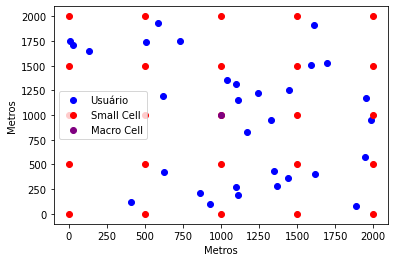

<ipython-input-63-7cac5e171799>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['DR'][i+Us.index[0]] =T*PR
<ipython-input-63-7cac5e171799>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['PRB'][i+Us.index[0]] =PR
<ipython-input-63-7cac5e171799>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['EB'][i+Us.index[0]]= IND + 1
<ipython-input-63-7cac5e171799>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of

FatiasVazao [[5637.6444742384765], [11275.288948476953], [16912.93342271543], [22550.577896953906], [28188.22237119238]]
vazaoAgregadaClusters [{'vazaoAgregada': 3987.646715898051, 'label': 2}, {'vazaoAgregada': 3297.9691746305966, 'label': 4}, {'vazaoAgregada': 3138.6415327952973, 'label': 3}, {'vazaoAgregada': 2799.5337903710474, 'label': 11}, {'vazaoAgregada': 2208.849242615611, 'label': 14}, {'vazaoAgregada': 2072.775316592085, 'label': 15}, {'vazaoAgregada': 1604.20309760493, 'label': 1}, {'vazaoAgregada': 1475.4724552269188, 'label': 7}, {'vazaoAgregada': 1453.4521605835257, 'label': 12}, {'vazaoAgregada': 1344.77309715429, 'label': 10}, {'vazaoAgregada': 1286.5592288867879, 'label': 9}, {'vazaoAgregada': 962.7509759137313, 'label': 8}, {'vazaoAgregada': 925.6318132000112, 'label': 6}, {'vazaoAgregada': 746.8568333316676, 'label': 13}, {'vazaoAgregada': 470.2836712720188, 'label': 0}, {'vazaoAgregada': 412.82326511581095, 'label': 16}, {'vazaoAgregada': 0.0, 'label': 5}, {'vazaoA

sse [113817890.2372684, 38046204.36277422, 15129900.120908782, 10616518.434799757, 7045907.207986967, 4777464.9689218635, 3263567.259256438, 2127490.8179456997, 1333611.7922361703]


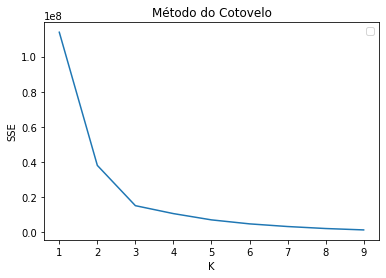

<ipython-input-63-7cac5e171799>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['DR'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['PRB'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['EB'][i+Us.index[0]]= 0
<ipython-input-63-7cac5e171799>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

fatiaVazaoAgregada [5637.6444742384765]
antenasNecessariasParaSuprirUmMomento [{'id': 17.0, 'DrMean': 1475.4724552269188}, {'id': 4.0, 'DrMean': 925.6318132000112}, {'id': 11.0, 'DrMean': 1286.5592288867879}, {'id': 19.0, 'DrMean': 1604.20309760493}, {'id': 13.0, 'DrMean': 962.7509759137313}]
Momento Atual -------------------------------------------------------------------------------------------------- 2


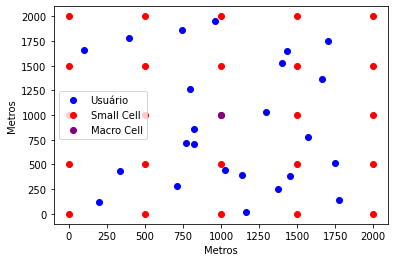

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


FatiasVazao [[3611.2329187865953], [7222.465837573191], [10833.698756359785], [14444.931675146381], [18056.164593932976]]
vazaoAgregadaClusters [{'vazaoAgregada': 4279.264663151197, 'label': 3}, {'vazaoAgregada': 2006.1403253084184, 'label': 7}, {'vazaoAgregada': 1857.6066545376107, 'label': 1}, {'vazaoAgregada': 1653.8971885026028, 'label': 8}, {'vazaoAgregada': 1511.473964451795, 'label': 4}, {'vazaoAgregada': 1426.2376445929751, 'label': 5}, {'vazaoAgregada': 1360.068163717957, 'label': 12}, {'vazaoAgregada': 784.9705853749973, 'label': 11}, {'vazaoAgregada': 746.4378888742453, 'label': 13}, {'vazaoAgregada': 713.8758017013835, 'label': 10}, {'vazaoAgregada': 672.4497928472542, 'label': 6}, {'vazaoAgregada': 587.972533335768, 'label': 0}, {'vazaoAgregada': 455.7693875367709, 'label': 9}, {'vazaoAgregada': 0.0, 'label': 2}, {'vazaoAgregada': 0.0, 'label': 14}, {'vazaoAgregada': 0.0, 'label': 15}, {'vazaoAgregada': 0.0, 'label': 16}, {'vazaoAgregada': 0.0, 'label': 17}]
clustersUsados

sse [98231397.68820879, 23595703.438011654, 11223118.588700391, 6016728.253758229, 2679633.159182726, 917588.0072174828, 376369.98527388484, 259672.47238791056, 149318.71562465696]


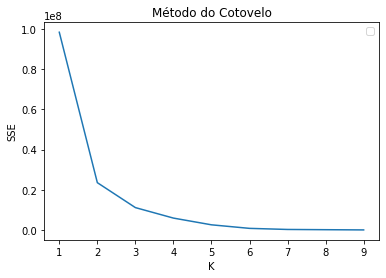

<ipython-input-63-7cac5e171799>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['DR'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['PRB'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['EB'][i+Us.index[0]]= 0
<ipython-input-63-7cac5e171799>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

fatiaVazaoAgregada [3611.2329187865953]
antenasNecessariasParaSuprirUmMomento [{'id': 12.0, 'DrMean': 2006.1403253084184}, {'id': 19.0, 'DrMean': 1857.6066545376107}]
Momento Atual -------------------------------------------------------------------------------------------------- 3


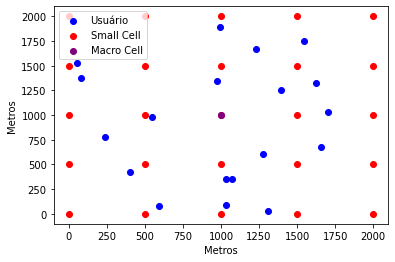

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


FatiasVazao [[4956.702734556999], [9913.405469113997], [14870.108203670992], [19826.810938227994], [24783.51367278499]]
vazaoAgregadaClusters [{'vazaoAgregada': 4581.069354057433, 'label': 4}, {'vazaoAgregada': 3122.3032577430204, 'label': 3}, {'vazaoAgregada': 3071.6809966732153, 'label': 9}, {'vazaoAgregada': 2778.353177744177, 'label': 1}, {'vazaoAgregada': 2525.258869800132, 'label': 12}, {'vazaoAgregada': 2430.199258693561, 'label': 7}, {'vazaoAgregada': 1759.9391926847575, 'label': 5}, {'vazaoAgregada': 1241.6826322259924, 'label': 6}, {'vazaoAgregada': 1055.6152659685613, 'label': 8}, {'vazaoAgregada': 837.7022205369952, 'label': 11}, {'vazaoAgregada': 739.1920643215271, 'label': 0}, {'vazaoAgregada': 640.5173823356189, 'label': 10}, {'vazaoAgregada': 0.0, 'label': 2}, {'vazaoAgregada': 0.0, 'label': 13}, {'vazaoAgregada': 0.0, 'label': 14}, {'vazaoAgregada': 0.0, 'label': 15}, {'vazaoAgregada': 0.0, 'label': 16}, {'vazaoAgregada': 0.0, 'label': 17}]
clustersUsados [{'vazaoAgreg

sse [114850243.88612434, 27610505.546404906, 13775403.696508393, 5626253.745305847, 3178567.5397006776, 1474571.71602243, 803094.5598760558, 402898.90890581545, 193795.0587737769]


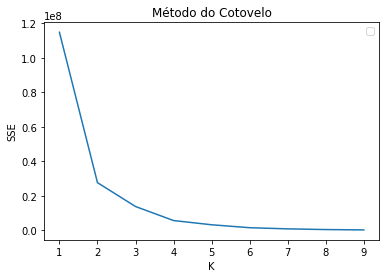

<ipython-input-63-7cac5e171799>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['DR'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['PRB'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['EB'][i+Us.index[0]]= 0
<ipython-input-63-7cac5e171799>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

fatiaVazaoAgregada [4956.702734556999]
antenasNecessariasParaSuprirUmMomento [{'id': 4.0, 'DrMean': 3122.3032577430204}, {'id': 12.0, 'DrMean': 1759.9391926847575}, {'id': 14.0, 'DrMean': 1241.6826322259924}]
Momento Atual -------------------------------------------------------------------------------------------------- 4


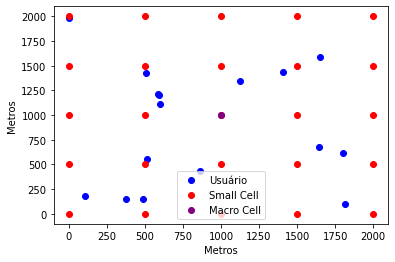

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
<ipython-input-70-a5e07d73fc62>:33: RuntimeWarning: invalid value encountered in double_scalars
  "DataRateMean": TotalDataRate/TotalUsers,


FatiasVazao [[5416.479528143846], [10832.959056287693], [16249.438584431538], [21665.918112575386], [27082.39764071923]]
vazaoAgregadaClusters [{'vazaoAgregada': 7286.09938289407, 'label': 3}, {'vazaoAgregada': 4423.889233730182, 'label': 7}, {'vazaoAgregada': 3861.5220316995337, 'label': 2}, {'vazaoAgregada': 2120.7861105021857, 'label': 1}, {'vazaoAgregada': 1888.2888158189044, 'label': 6}, {'vazaoAgregada': 1606.5822828291455, 'label': 5}, {'vazaoAgregada': 1208.100224619687, 'label': 10}, {'vazaoAgregada': 1147.3234490690786, 'label': 9}, {'vazaoAgregada': 1022.9605387572541, 'label': 8}, {'vazaoAgregada': 977.3043272146199, 'label': 12}, {'vazaoAgregada': 796.9473471097558, 'label': 11}, {'vazaoAgregada': 742.5938964748083, 'label': 0}, {'vazaoAgregada': 0.0, 'label': 4}, {'vazaoAgregada': 0.0, 'label': 13}, {'vazaoAgregada': 0.0, 'label': 14}, {'vazaoAgregada': 0.0, 'label': 15}, {'vazaoAgregada': 0.0, 'label': 16}, {'vazaoAgregada': 0.0, 'label': 17}]
clustersUsados [{'vazaoAgre

sse [166950723.16902092, 49053392.03511958, 19709407.124608606, 10498870.532824364, 3122054.3285582312, 1653423.0243599864, 727507.7874520174, 411236.4175322373, 195598.83039384248]


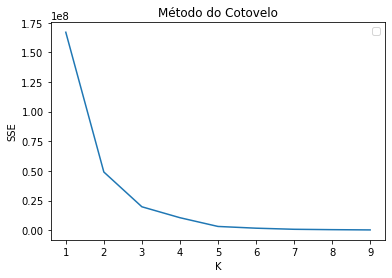

<ipython-input-63-7cac5e171799>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['DR'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['PRB'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['EB'][i+Us.index[0]]= 0
<ipython-input-63-7cac5e171799>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

fatiaVazaoAgregada [5416.479528143846]
antenasNecessariasParaSuprirUmMomento [{'id': 8.0, 'DrMean': 1147.3234490690786}, {'id': 6.0, 'DrMean': 1606.5822828291455}, {'id': 19.0, 'DrMean': 2120.7861105021857}, {'id': 1.0, 'DrMean': 1022.9605387572541}]
Momento Atual -------------------------------------------------------------------------------------------------- 5


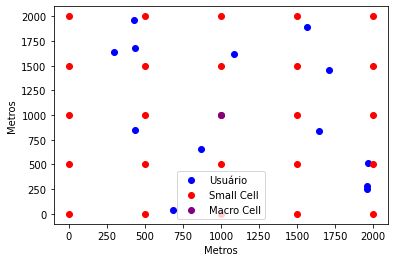

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
<ipython-input-70-a5e07d73fc62>:33: RuntimeWarning: invalid value encountered in double_scalars
  "DataRateMean": TotalDataRate/TotalUsers,


FatiasVazao [[3657.606246775651], [7315.212493551302], [10972.818740326951], [14630.424987102604], [18288.031233878253]]
vazaoAgregadaClusters [{'vazaoAgregada': 3647.7151255930817, 'label': 1}, {'vazaoAgregada': 3123.9002900195082, 'label': 3}, {'vazaoAgregada': 2401.3853821155903, 'label': 8}, {'vazaoAgregada': 2059.1380032845245, 'label': 4}, {'vazaoAgregada': 1533.037043941272, 'label': 7}, {'vazaoAgregada': 1140.888850713355, 'label': 6}, {'vazaoAgregada': 1085.5468718028167, 'label': 11}, {'vazaoAgregada': 949.1734476023362, 'label': 5}, {'vazaoAgregada': 899.9455166791826, 'label': 9}, {'vazaoAgregada': 762.6793095025456, 'label': 0}, {'vazaoAgregada': 684.6213926240399, 'label': 10}, {'vazaoAgregada': 0.0, 'label': 2}, {'vazaoAgregada': 0.0, 'label': 12}, {'vazaoAgregada': 0.0, 'label': 13}, {'vazaoAgregada': 0.0, 'label': 14}, {'vazaoAgregada': 0.0, 'label': 15}, {'vazaoAgregada': 0.0, 'label': 16}, {'vazaoAgregada': 0.0, 'label': 17}]
clustersUsados [{'vazaoAgregada': 3647.71

sse [79927614.63881904, 24819809.395499837, 9329231.208368897, 4416537.568135741, 1737589.2555754487, 668884.8921753513, 403941.1929487741, 168941.4980837361, 51782.229767001045]


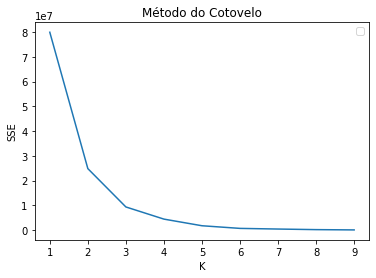

<ipython-input-63-7cac5e171799>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['DR'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['PRB'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['EB'][i+Us.index[0]]= 0
<ipython-input-63-7cac5e171799>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

fatiaVazaoAgregada [3657.606246775651]
antenasNecessariasParaSuprirUmMomento [{'id': 9.0, 'DrMean': 949.1734476023362}, {'id': 22.0, 'DrMean': 3123.9002900195082}]
Momento Atual -------------------------------------------------------------------------------------------------- 6


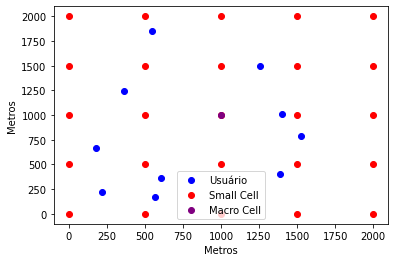

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


FatiasVazao [[2087.0424263562472], [4174.0848527124945], [6261.127279068742], [8348.169705424989], [10435.212131781236]]
vazaoAgregadaClusters [{'vazaoAgregada': 1952.7914690227176, 'label': 6}, {'vazaoAgregada': 1877.3435261751818, 'label': 2}, {'vazaoAgregada': 1833.3938966007524, 'label': 4}, {'vazaoAgregada': 1532.3336057891104, 'label': 1}, {'vazaoAgregada': 1218.9454784146412, 'label': 5}, {'vazaoAgregada': 760.935663404302, 'label': 7}, {'vazaoAgregada': 661.2237200873254, 'label': 3}, {'vazaoAgregada': 598.2447722872057, 'label': 8}, {'vazaoAgregada': 0.0, 'label': 0}, {'vazaoAgregada': 0.0, 'label': 9}, {'vazaoAgregada': 0.0, 'label': 10}, {'vazaoAgregada': 0.0, 'label': 11}, {'vazaoAgregada': 0.0, 'label': 12}, {'vazaoAgregada': 0.0, 'label': 13}, {'vazaoAgregada': 0.0, 'label': 14}, {'vazaoAgregada': 0.0, 'label': 15}, {'vazaoAgregada': 0.0, 'label': 16}, {'vazaoAgregada': 0.0, 'label': 17}]
clustersUsados [{'vazaoAgregada': 1952.7914690227176, 'label': 6}, {'vazaoAgregada':

sse [31969809.53328654, 6633644.687285664, 2989750.3579029664, 662592.627090787, 140915.66238522358, 42695.04400594707, 19611.12816626859, 5328.8478660102055, 1332.0]


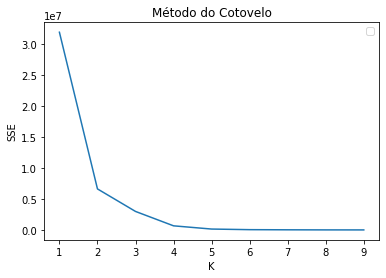

<ipython-input-63-7cac5e171799>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['DR'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['PRB'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['EB'][i+Us.index[0]]= 0
<ipython-input-63-7cac5e171799>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

fatiaVazaoAgregada [2087.0424263562472]
antenasNecessariasParaSuprirUmMomento [{'id': 18.0, 'DrMean': 1877.3435261751818}, {'id': 2.0, 'DrMean': 661.2237200873254}]
Momento Atual -------------------------------------------------------------------------------------------------- 7


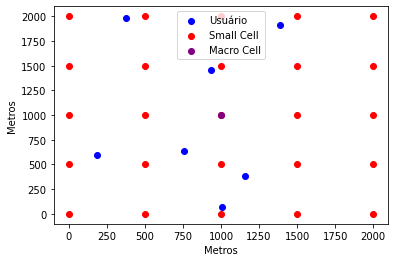

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
<ipython-input-70-a5e07d73fc62>:33: RuntimeWarning: invalid value encountered in double_scalars
  "DataRateMean": TotalDataRate/TotalUsers,


FatiasVazao [[2768.7054617063586], [5537.410923412717], [8306.116385119074], [11074.821846825434], [13843.527308531791]]
vazaoAgregadaClusters [{'vazaoAgregada': 3814.3413591546764, 'label': 6}, {'vazaoAgregada': 3508.01410774692, 'label': 0}, {'vazaoAgregada': 2536.8057112337538, 'label': 5}, {'vazaoAgregada': 2118.8416121912687, 'label': 2}, {'vazaoAgregada': 957.1286709722273, 'label': 3}, {'vazaoAgregada': 908.3958472329448, 'label': 4}, {'vazaoAgregada': 0.0, 'label': 1}, {'vazaoAgregada': 0.0, 'label': 7}, {'vazaoAgregada': 0.0, 'label': 8}, {'vazaoAgregada': 0.0, 'label': 9}, {'vazaoAgregada': 0.0, 'label': 10}, {'vazaoAgregada': 0.0, 'label': 11}, {'vazaoAgregada': 0.0, 'label': 12}, {'vazaoAgregada': 0.0, 'label': 13}, {'vazaoAgregada': 0.0, 'label': 14}, {'vazaoAgregada': 0.0, 'label': 15}, {'vazaoAgregada': 0.0, 'label': 16}, {'vazaoAgregada': 0.0, 'label': 17}]
clustersUsados [{'vazaoAgregada': 3814.3413591546764, 'label': 6}]
clustersFinais [    MicroID  UsersConnected  To

sse [65149967.25333998, 9251925.69995299, 3446768.521045368, 640822.8109214668, 270074.1098855322, 95325.62179713593, 1466.7368421052631, 558.4772727272727, 334.060606060606]


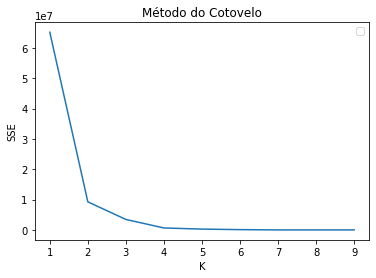

<ipython-input-63-7cac5e171799>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['DR'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['PRB'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['EB'][i+Us.index[0]]= 0
<ipython-input-63-7cac5e171799>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

fatiaVazaoAgregada [2768.7054617063586]
antenasNecessariasParaSuprirUmMomento [{'id': 12.0, 'DrMean': 908.3958472329448}, {'id': 2.0, 'DrMean': 957.1286709722273}, {'id': 10.0, 'DrMean': 2536.8057112337538}]
Momento Atual -------------------------------------------------------------------------------------------------- 8


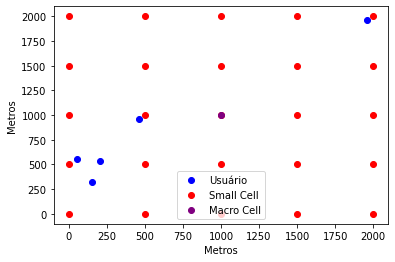

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
<ipython-input-70-a5e07d73fc62>:33: RuntimeWarning: invalid value encountered in double_scalars
  "DataRateMean": TotalDataRate/TotalUsers,


FatiasVazao [[2175.124459548171], [4350.248919096342], [6525.373378644514], [8700.497838192685], [10875.622297740856]]
vazaoAgregadaClusters [{'vazaoAgregada': 4584.130984449286, 'label': 3}, {'vazaoAgregada': 4479.974004078672, 'label': 1}, {'vazaoAgregada': 1811.5173092128978, 'label': 2}, {'vazaoAgregada': 0.0, 'label': 0}, {'vazaoAgregada': 0.0, 'label': 4}, {'vazaoAgregada': 0.0, 'label': 5}, {'vazaoAgregada': 0.0, 'label': 6}, {'vazaoAgregada': 0.0, 'label': 7}, {'vazaoAgregada': 0.0, 'label': 8}, {'vazaoAgregada': 0.0, 'label': 9}, {'vazaoAgregada': 0.0, 'label': 10}, {'vazaoAgregada': 0.0, 'label': 11}, {'vazaoAgregada': 0.0, 'label': 12}, {'vazaoAgregada': 0.0, 'label': 13}, {'vazaoAgregada': 0.0, 'label': 14}, {'vazaoAgregada': 0.0, 'label': 15}, {'vazaoAgregada': 0.0, 'label': 16}, {'vazaoAgregada': 0.0, 'label': 17}]
clustersUsados [{'vazaoAgregada': 4584.130984449286, 'label': 3}]
clustersFinais [    MicroID  UsersConnected  TotalDataRate  DataRateMean  Moment  Label
24   

sse [101847083.9859637, 5489817.153758023, 12463.040196288217, 1467.8636363636365, 599.8181818181819, 419.95404040404037, 293.5486111111111, 188.2857142857143, 115.41666666666666]


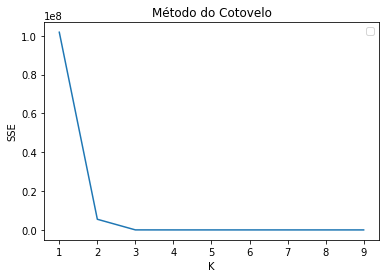

<ipython-input-63-7cac5e171799>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['DR'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['PRB'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['EB'][i+Us.index[0]]= 0
<ipython-input-63-7cac5e171799>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

fatiaVazaoAgregada [2175.124459548171]
antenasNecessariasParaSuprirUmMomento [{'id': 2.0, 'DrMean': 1811.5173092128978}, {'id': 8.0, 'DrMean': 4479.974004078672}]
Momento Atual -------------------------------------------------------------------------------------------------- 9


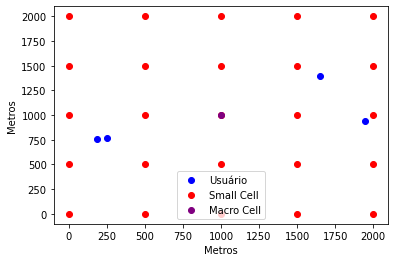

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


FatiasVazao [[1019.4669693754837], [2038.9339387509674], [3058.4009081264508], [4077.867877501935], [5097.334846877418]]
vazaoAgregadaClusters [{'vazaoAgregada': 3733.034171256508, 'label': 1}, {'vazaoAgregada': 1364.3006756209106, 'label': 2}, {'vazaoAgregada': 0.0, 'label': 0}, {'vazaoAgregada': 0.0, 'label': 3}, {'vazaoAgregada': 0.0, 'label': 4}, {'vazaoAgregada': 0.0, 'label': 5}, {'vazaoAgregada': 0.0, 'label': 6}, {'vazaoAgregada': 0.0, 'label': 7}, {'vazaoAgregada': 0.0, 'label': 8}, {'vazaoAgregada': 0.0, 'label': 9}, {'vazaoAgregada': 0.0, 'label': 10}, {'vazaoAgregada': 0.0, 'label': 11}, {'vazaoAgregada': 0.0, 'label': 12}, {'vazaoAgregada': 0.0, 'label': 13}, {'vazaoAgregada': 0.0, 'label': 14}, {'vazaoAgregada': 0.0, 'label': 15}, {'vazaoAgregada': 0.0, 'label': 16}, {'vazaoAgregada': 0.0, 'label': 17}]
clustersUsados [{'vazaoAgregada': 3733.034171256508, 'label': 1}]
clustersFinais [    MicroID  UsersConnected  TotalDataRate  DataRateMean  Moment  Label
22     23.0      

sse [29516973.91124161, 3569246.264207707, 1638.6086956521738, 770.0151515151515, 488.0051948051948, 344.6333333333333, 234.41666666666663, 144.24999999999997, 110.33333333333334]


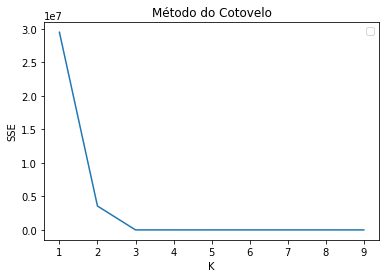

<ipython-input-63-7cac5e171799>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['DR'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['PRB'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['EB'][i+Us.index[0]]= 0
<ipython-input-63-7cac5e171799>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

fatiaVazaoAgregada [1019.4669693754837]
antenasNecessariasParaSuprirUmMomento [{'id': 19.0, 'DrMean': 1364.3006756209106}]
Momento Atual -------------------------------------------------------------------------------------------------- 10


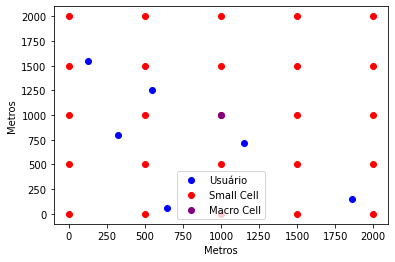

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
<ipython-input-70-a5e07d73fc62>:33: RuntimeWarning: invalid value encountered in double_scalars
  "DataRateMean": TotalDataRate/TotalUsers,


FatiasVazao [[1376.036480561553], [2752.072961123106], [4128.109441684658], [5504.145922246212], [6880.182402807764]]
vazaoAgregadaClusters [{'vazaoAgregada': 2262.3461136013625, 'label': 4}, {'vazaoAgregada': 1808.4236730942876, 'label': 0}, {'vazaoAgregada': 1113.9079517982377, 'label': 5}, {'vazaoAgregada': 766.5940683723371, 'label': 2}, {'vazaoAgregada': 473.3929254178728, 'label': 7}, {'vazaoAgregada': 455.51767052366597, 'label': 3}, {'vazaoAgregada': 0.0, 'label': 1}, {'vazaoAgregada': 0.0, 'label': 6}, {'vazaoAgregada': 0.0, 'label': 8}, {'vazaoAgregada': 0.0, 'label': 9}, {'vazaoAgregada': 0.0, 'label': 10}, {'vazaoAgregada': 0.0, 'label': 11}, {'vazaoAgregada': 0.0, 'label': 12}, {'vazaoAgregada': 0.0, 'label': 13}, {'vazaoAgregada': 0.0, 'label': 14}, {'vazaoAgregada': 0.0, 'label': 15}, {'vazaoAgregada': 0.0, 'label': 16}, {'vazaoAgregada': 0.0, 'label': 17}]
clustersUsados [{'vazaoAgregada': 2262.3461136013625, 'label': 4}]
clustersFinais [   MicroID  UsersConnected  Tota

sse [17512273.368073586, 3117166.0838405704, 781300.3833711452, 329530.3625240042, 122454.43204212346, 1750.9984217433912, 951.2866422947696, 615.7619047619048, 401.48611111111114]


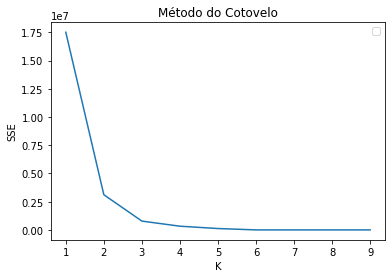

<ipython-input-63-7cac5e171799>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['DR'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['PRB'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['EB'][i+Us.index[0]]= 0
<ipython-input-63-7cac5e171799>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

fatiaVazaoAgregada [1376.036480561553]
antenasNecessariasParaSuprirUmMomento [{'id': 4.0, 'DrMean': 2262.3461136013625}]
Momento Atual -------------------------------------------------------------------------------------------------- 11


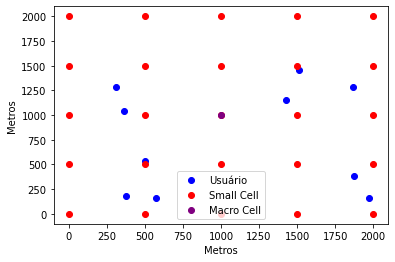

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
<ipython-input-70-a5e07d73fc62>:33: RuntimeWarning: invalid value encountered in double_scalars
  "DataRateMean": TotalDataRate/TotalUsers,


FatiasVazao [[3934.910789532163], [7869.821579064326], [11804.732368596488], [15739.643158128652], [19674.553947660814]]
vazaoAgregadaClusters [{'vazaoAgregada': 5532.217872968886, 'label': 4}, {'vazaoAgregada': 4969.515455965448, 'label': 1}, {'vazaoAgregada': 2010.409903207397, 'label': 6}, {'vazaoAgregada': 1672.2058945053925, 'label': 2}, {'vazaoAgregada': 1627.9833646179463, 'label': 9}, {'vazaoAgregada': 1506.0143020421262, 'label': 8}, {'vazaoAgregada': 1113.4691947283395, 'label': 5}, {'vazaoAgregada': 732.8509235199782, 'label': 3}, {'vazaoAgregada': 509.88703610529626, 'label': 7}, {'vazaoAgregada': 0.0, 'label': 0}, {'vazaoAgregada': 0.0, 'label': 10}, {'vazaoAgregada': 0.0, 'label': 11}, {'vazaoAgregada': 0.0, 'label': 12}, {'vazaoAgregada': 0.0, 'label': 13}, {'vazaoAgregada': 0.0, 'label': 14}, {'vazaoAgregada': 0.0, 'label': 15}, {'vazaoAgregada': 0.0, 'label': 16}, {'vazaoAgregada': 0.0, 'label': 17}]
clustersUsados [{'vazaoAgregada': 5532.217872968886, 'label': 4}]
clu

sse [109141901.41518667, 23365990.074509114, 2518515.2336933715, 1145622.300043513, 647749.4232801953, 331038.9131786849, 80809.90244489815, 30976.507353831177, 3285.3196496460696]


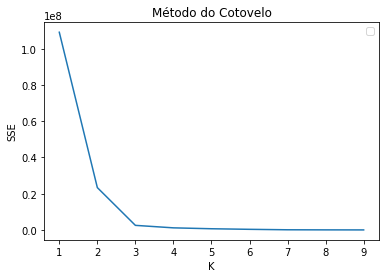

<ipython-input-63-7cac5e171799>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['DR'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['PRB'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['EB'][i+Us.index[0]]= 0
<ipython-input-63-7cac5e171799>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

fatiaVazaoAgregada [3934.910789532163]
antenasNecessariasParaSuprirUmMomento [{'id': 6.0, 'DrMean': 1113.4691947283395}, {'id': 7.0, 'DrMean': 5532.217872968886}]
Momento Atual -------------------------------------------------------------------------------------------------- 12


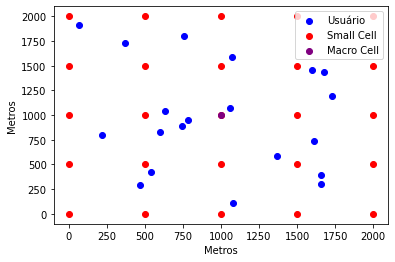

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


FatiasVazao [[3407.0750093846], [6814.1500187692], [10221.2250281538], [13628.3000375384], [17035.375046923]]
vazaoAgregadaClusters [{'vazaoAgregada': 2820.750459965326, 'label': 9}, {'vazaoAgregada': 2680.863513598301, 'label': 2}, {'vazaoAgregada': 2138.9149102955976, 'label': 5}, {'vazaoAgregada': 2102.893436490362, 'label': 6}, {'vazaoAgregada': 1958.0683376141242, 'label': 10}, {'vazaoAgregada': 1906.851435375214, 'label': 1}, {'vazaoAgregada': 1300.1188093682968, 'label': 7}, {'vazaoAgregada': 1019.3552785397426, 'label': 4}, {'vazaoAgregada': 656.8133395216701, 'label': 3}, {'vazaoAgregada': 450.74552615436784, 'label': 8}, {'vazaoAgregada': 0.0, 'label': 0}, {'vazaoAgregada': 0.0, 'label': 11}, {'vazaoAgregada': 0.0, 'label': 12}, {'vazaoAgregada': 0.0, 'label': 13}, {'vazaoAgregada': 0.0, 'label': 14}, {'vazaoAgregada': 0.0, 'label': 15}, {'vazaoAgregada': 0.0, 'label': 16}, {'vazaoAgregada': 0.0, 'label': 17}]
clustersUsados [{'vazaoAgregada': 2820.750459965326, 'label': 9}, 

sse [90269857.9142565, 7978364.943526242, 2629651.2208703957, 1547054.3318078145, 721170.795038553, 221953.2440164021, 125073.76080262076, 69938.22915724755, 27443.785451266245]


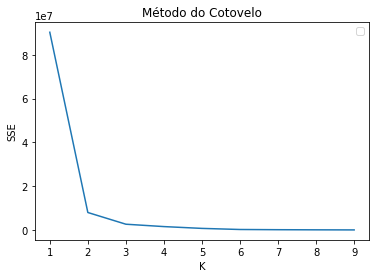

<ipython-input-63-7cac5e171799>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['DR'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['PRB'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['EB'][i+Us.index[0]]= 0
<ipython-input-63-7cac5e171799>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

fatiaVazaoAgregada [3407.0750093846]
antenasNecessariasParaSuprirUmMomento [{'id': 17.0, 'DrMean': 1019.3552785397426}, {'id': 8.0, 'DrMean': 1300.1188093682968}, {'id': 7.0, 'DrMean': 2102.893436490362}]
Momento Atual -------------------------------------------------------------------------------------------------- 13


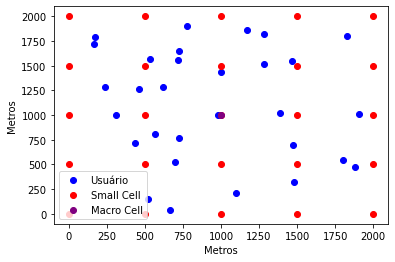

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


FatiasVazao [[6055.113665656172], [12110.227331312344], [18165.340996968516], [24220.45466262469], [30275.56832828086]]
vazaoAgregadaClusters [{'vazaoAgregada': 6683.210932927916, 'label': 2}, {'vazaoAgregada': 4145.7144785550145, 'label': 7}, {'vazaoAgregada': 3160.6653662773383, 'label': 4}, {'vazaoAgregada': 2670.4618243388577, 'label': 10}, {'vazaoAgregada': 2576.6229103536207, 'label': 0}, {'vazaoAgregada': 1748.6208779052072, 'label': 16}, {'vazaoAgregada': 1695.6659061227856, 'label': 5}, {'vazaoAgregada': 1153.8147971541662, 'label': 8}, {'vazaoAgregada': 1135.516393458648, 'label': 3}, {'vazaoAgregada': 1016.9517109461062, 'label': 12}, {'vazaoAgregada': 790.6235808572487, 'label': 9}, {'vazaoAgregada': 787.9941421902992, 'label': 13}, {'vazaoAgregada': 724.4026931851291, 'label': 14}, {'vazaoAgregada': 632.4006992810754, 'label': 11}, {'vazaoAgregada': 516.5388480006374, 'label': 15}, {'vazaoAgregada': 434.7391319528792, 'label': 17}, {'vazaoAgregada': 401.62403477393, 'label

sse [159908329.1672614, 48071446.09078879, 25950146.117709838, 16404390.955455419, 9390054.704939052, 5801290.013434749, 3907973.9770249613, 2204118.485104293, 1002218.3571684036]


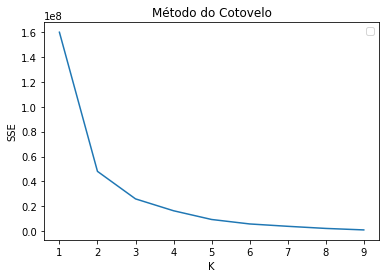

<ipython-input-63-7cac5e171799>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['DR'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['PRB'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['EB'][i+Us.index[0]]= 0
<ipython-input-63-7cac5e171799>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

fatiaVazaoAgregada [6055.113665656172]
antenasNecessariasParaSuprirUmMomento [{'id': 9.0, 'DrMean': 1153.8147971541662}, {'id': 6.0, 'DrMean': 1695.6659061227856}, {'id': 7.0, 'DrMean': 790.6235808572487}, {'id': 8.0, 'DrMean': 1016.9517109461062}, {'id': 15.0, 'DrMean': 724.4026931851291}, {'id': 17.0, 'DrMean': 1135.516393458648}]
Momento Atual -------------------------------------------------------------------------------------------------- 14


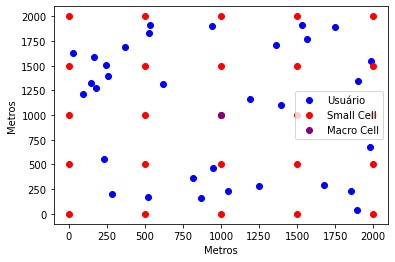

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


FatiasVazao [[4699.825009666611], [9399.650019333221], [14099.47502899983], [18799.300038666443], [23499.12504833305]]
vazaoAgregadaClusters [{'vazaoAgregada': 3165.023939464746, 'label': 5}, {'vazaoAgregada': 2656.7630323712106, 'label': 6}, {'vazaoAgregada': 2513.0522021757897, 'label': 12}, {'vazaoAgregada': 2268.9161936155756, 'label': 0}, {'vazaoAgregada': 1936.081274859783, 'label': 10}, {'vazaoAgregada': 1584.6939604722932, 'label': 9}, {'vazaoAgregada': 1452.38340920656, 'label': 8}, {'vazaoAgregada': 1367.2708287540659, 'label': 7}, {'vazaoAgregada': 1173.4794263447711, 'label': 3}, {'vazaoAgregada': 1091.4348217188754, 'label': 2}, {'vazaoAgregada': 782.9126263143711, 'label': 13}, {'vazaoAgregada': 781.6232934416287, 'label': 11}, {'vazaoAgregada': 630.354949808653, 'label': 17}, {'vazaoAgregada': 597.3925682883136, 'label': 1}, {'vazaoAgregada': 548.2582437790468, 'label': 16}, {'vazaoAgregada': 505.3784926730593, 'label': 14}, {'vazaoAgregada': 444.1057850443058, 'label': 

sse [120598188.56256667, 30878871.544831343, 12455219.46138586, 9545789.760076255, 6750247.835796673, 4921505.937031081, 3215685.3662035954, 2332661.8480365505, 1624976.5703454912]


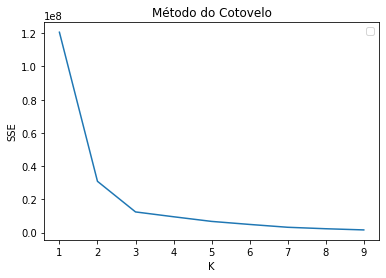

<ipython-input-63-7cac5e171799>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['DR'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['PRB'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['EB'][i+Us.index[0]]= 0
<ipython-input-63-7cac5e171799>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

fatiaVazaoAgregada [4699.825009666611]
antenasNecessariasParaSuprirUmMomento [{'id': 4.0, 'DrMean': 1173.4794263447711}, {'id': 9.0, 'DrMean': 782.9126263143711}, {'id': 20.0, 'DrMean': 1452.38340920656}, {'id': 6.0, 'DrMean': 1091.4348217188754}, {'id': 10.0, 'DrMean': 2268.9161936155756}]
Momento Atual -------------------------------------------------------------------------------------------------- 15


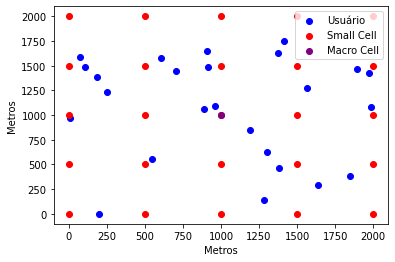

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


FatiasVazao [[5849.809853091317], [11699.619706182633], [17549.429559273947], [23399.239412365267], [29249.049265456582]]
vazaoAgregadaClusters [{'vazaoAgregada': 6004.306772595031, 'label': 4}, {'vazaoAgregada': 3660.0424184131853, 'label': 3}, {'vazaoAgregada': 3453.4355005075117, 'label': 13}, {'vazaoAgregada': 3175.436479990917, 'label': 8}, {'vazaoAgregada': 2470.2057050912604, 'label': 0}, {'vazaoAgregada': 2116.0456120882614, 'label': 6}, {'vazaoAgregada': 1981.6915577889165, 'label': 12}, {'vazaoAgregada': 1525.964335227624, 'label': 2}, {'vazaoAgregada': 1255.8720815310376, 'label': 11}, {'vazaoAgregada': 1237.7056905582801, 'label': 7}, {'vazaoAgregada': 978.4775447419892, 'label': 5}, {'vazaoAgregada': 881.9458107792847, 'label': 9}, {'vazaoAgregada': 507.91975614328396, 'label': 10}, {'vazaoAgregada': 0.0, 'label': 1}, {'vazaoAgregada': 0.0, 'label': 14}, {'vazaoAgregada': 0.0, 'label': 15}, {'vazaoAgregada': 0.0, 'label': 16}, {'vazaoAgregada': 0.0, 'label': 17}]
clustersU

sse [198354948.66007835, 42520444.72782665, 24586660.36942167, 14390061.84569215, 7599261.555759896, 3569911.2656348487, 2350431.627592497, 1476349.9187465038, 947915.8187314961]


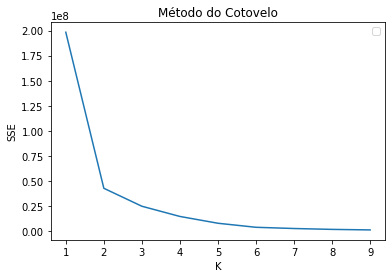

<ipython-input-63-7cac5e171799>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['DR'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['PRB'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['EB'][i+Us.index[0]]= 0
<ipython-input-63-7cac5e171799>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

fatiaVazaoAgregada [5849.809853091317]
antenasNecessariasParaSuprirUmMomento [{'id': 4.0, 'DrMean': 2116.0456120882614}, {'id': 13.0, 'DrMean': 1981.6915577889165}, {'id': 17.0, 'DrMean': 1237.7056905582801}, {'id': 19.0, 'DrMean': 881.9458107792847}]
Momento Atual -------------------------------------------------------------------------------------------------- 16


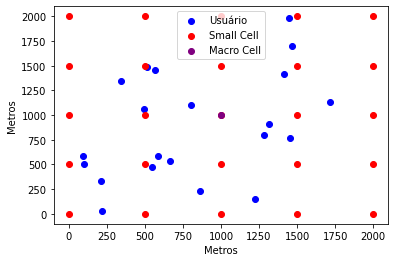

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
<ipython-input-70-a5e07d73fc62>:33: RuntimeWarning: invalid value encountered in double_scalars
  "DataRateMean": TotalDataRate/TotalUsers,


FatiasVazao [[4355.948794604728], [8711.897589209457], [13067.846383814183], [17423.795178418914], [21779.74397302364]]
vazaoAgregadaClusters [{'vazaoAgregada': 4431.818037481201, 'label': 9}, {'vazaoAgregada': 4294.8699733766125, 'label': 3}, {'vazaoAgregada': 3759.1615613086615, 'label': 2}, {'vazaoAgregada': 2799.1152077129686, 'label': 5}, {'vazaoAgregada': 1980.3880183743565, 'label': 1}, {'vazaoAgregada': 1721.7547789376283, 'label': 4}, {'vazaoAgregada': 781.4643269866689, 'label': 6}, {'vazaoAgregada': 748.1408108363421, 'label': 11}, {'vazaoAgregada': 663.4654033268368, 'label': 7}, {'vazaoAgregada': 599.5658546823647, 'label': 8}, {'vazaoAgregada': 0.0, 'label': 0}, {'vazaoAgregada': 0.0, 'label': 10}, {'vazaoAgregada': 0.0, 'label': 12}, {'vazaoAgregada': 0.0, 'label': 13}, {'vazaoAgregada': 0.0, 'label': 14}, {'vazaoAgregada': 0.0, 'label': 15}, {'vazaoAgregada': 0.0, 'label': 16}, {'vazaoAgregada': 0.0, 'label': 17}]
clustersUsados [{'vazaoAgregada': 4431.818037481201, 'la

sse [267986184.05234408, 61085524.96152846, 23887334.26111314, 14964722.11162037, 7716316.652933469, 4364725.100121953, 1036990.3510868362, 165223.21164133496, 21248.395657282214]


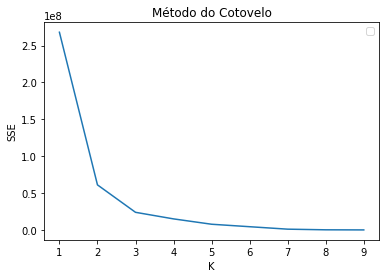

<ipython-input-63-7cac5e171799>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['DR'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['PRB'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['EB'][i+Us.index[0]]= 0
<ipython-input-63-7cac5e171799>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

fatiaVazaoAgregada [4355.948794604728]
antenasNecessariasParaSuprirUmMomento [{'id': 18.0, 'DrMean': 663.4654033268368}, {'id': 2.0, 'DrMean': 1980.3880183743565}, {'id': 7.0, 'DrMean': 2799.1152077129686}]
Momento Atual -------------------------------------------------------------------------------------------------- 17


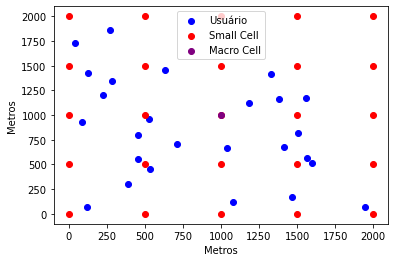

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


FatiasVazao [[5418.273330519889], [10836.546661039778], [16254.819991559663], [21673.093322079556], [27091.36665259944]]
vazaoAgregadaClusters [{'vazaoAgregada': 3587.248810103177, 'label': 6}, {'vazaoAgregada': 2759.4432148342016, 'label': 7}, {'vazaoAgregada': 2670.717652373427, 'label': 10}, {'vazaoAgregada': 2418.317102148964, 'label': 2}, {'vazaoAgregada': 2406.346874170535, 'label': 3}, {'vazaoAgregada': 2212.809721549154, 'label': 0}, {'vazaoAgregada': 1963.075915542169, 'label': 12}, {'vazaoAgregada': 1429.8883061533782, 'label': 8}, {'vazaoAgregada': 1324.042254119426, 'label': 14}, {'vazaoAgregada': 1303.275686719349, 'label': 5}, {'vazaoAgregada': 1261.5036921696303, 'label': 15}, {'vazaoAgregada': 1231.2970797585363, 'label': 13}, {'vazaoAgregada': 1195.5823552020584, 'label': 9}, {'vazaoAgregada': 889.7385852245781, 'label': 4}, {'vazaoAgregada': 438.0794025308492, 'label': 11}, {'vazaoAgregada': 0.0, 'label': 1}, {'vazaoAgregada': 0.0, 'label': 16}, {'vazaoAgregada': 0.0,

sse [178995158.40986934, 63239978.98270854, 22779868.623292334, 13914271.287935797, 9260804.486622646, 5668703.72237705, 3407167.6257707374, 1899517.9731545425, 1198126.1625062935]


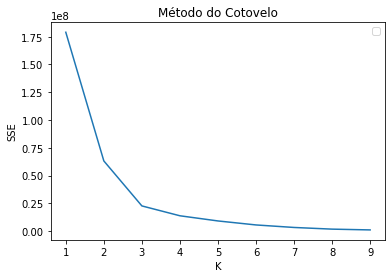

<ipython-input-63-7cac5e171799>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['DR'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['PRB'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['EB'][i+Us.index[0]]= 0
<ipython-input-63-7cac5e171799>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

fatiaVazaoAgregada [5418.273330519889]
antenasNecessariasParaSuprirUmMomento [{'id': 7.0, 'DrMean': 2418.317102148964}, {'id': 17.0, 'DrMean': 2406.346874170535}, {'id': 18.0, 'DrMean': 1195.5823552020584}]
Momento Atual -------------------------------------------------------------------------------------------------- 18


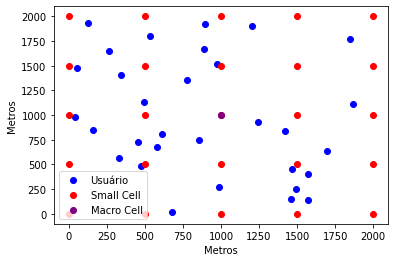

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
<ipython-input-70-a5e07d73fc62>:33: RuntimeWarning: invalid value encountered in double_scalars
  "DataRateMean": TotalDataRate/TotalUsers,


FatiasVazao [[5834.042197379222], [11668.084394758444], [17502.12659213766], [23336.168789516887], [29170.210986896105]]
vazaoAgregadaClusters [{'vazaoAgregada': 4426.21123751099, 'label': 6}, {'vazaoAgregada': 3039.529371549437, 'label': 1}, {'vazaoAgregada': 2393.12576719031, 'label': 8}, {'vazaoAgregada': 2319.3394023149585, 'label': 10}, {'vazaoAgregada': 2119.6114069890455, 'label': 3}, {'vazaoAgregada': 2075.9044836922376, 'label': 9}, {'vazaoAgregada': 1693.5499570706597, 'label': 13}, {'vazaoAgregada': 1531.0038874090378, 'label': 14}, {'vazaoAgregada': 1515.5351348750498, 'label': 17}, {'vazaoAgregada': 1471.2829488984755, 'label': 2}, {'vazaoAgregada': 1391.8537628800552, 'label': 16}, {'vazaoAgregada': 1310.2836178786106, 'label': 4}, {'vazaoAgregada': 1045.8179330849086, 'label': 7}, {'vazaoAgregada': 892.5594379165103, 'label': 15}, {'vazaoAgregada': 726.6530678993895, 'label': 12}, {'vazaoAgregada': 672.7606829605409, 'label': 11}, {'vazaoAgregada': 545.1888867758911, 'la

sse [216028042.57155818, 52939540.49648628, 27262798.121242255, 13613437.905530978, 8156531.545025537, 4700046.0469074575, 2858304.9892113614, 2043950.214288115, 1390665.5459036771]


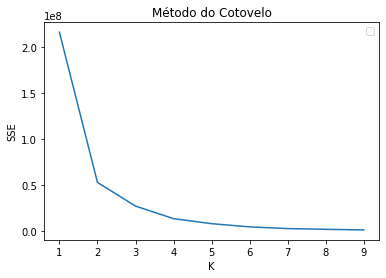

<ipython-input-63-7cac5e171799>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['DR'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['PRB'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['EB'][i+Us.index[0]]= 0
<ipython-input-63-7cac5e171799>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

fatiaVazaoAgregada [5834.042197379222]
antenasNecessariasParaSuprirUmMomento [{'id': 7.0, 'DrMean': 2319.3394023149585}, {'id': 17.0, 'DrMean': 2119.6114069890455}, {'id': 14.0, 'DrMean': 2393.12576719031}]
Momento Atual -------------------------------------------------------------------------------------------------- 19


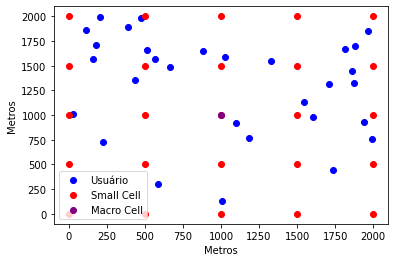

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


FatiasVazao [[6016.502799225105], [12033.00559845021], [18049.508397675316], [24066.01119690042], [30082.513996125526]]
vazaoAgregadaClusters [{'vazaoAgregada': 6284.562951118916, 'label': 4}, {'vazaoAgregada': 4107.26217456049, 'label': 1}, {'vazaoAgregada': 2426.3411572417754, 'label': 7}, {'vazaoAgregada': 2323.680779569104, 'label': 6}, {'vazaoAgregada': 2209.1316160857605, 'label': 14}, {'vazaoAgregada': 2052.05871856564, 'label': 5}, {'vazaoAgregada': 1890.5541343228767, 'label': 12}, {'vazaoAgregada': 1841.3369355796754, 'label': 3}, {'vazaoAgregada': 1470.972542925022, 'label': 11}, {'vazaoAgregada': 1212.2125831815783, 'label': 13}, {'vazaoAgregada': 1075.305816804041, 'label': 9}, {'vazaoAgregada': 967.8942659453699, 'label': 0}, {'vazaoAgregada': 893.1434158950839, 'label': 8}, {'vazaoAgregada': 886.3407040215651, 'label': 15}, {'vazaoAgregada': 441.7162003086322, 'label': 10}, {'vazaoAgregada': 0.0, 'label': 2}, {'vazaoAgregada': 0.0, 'label': 16}, {'vazaoAgregada': 0.0, 'l

sse [216701328.51352933, 69292799.91884428, 28422742.73017924, 17407498.919997294, 8084785.7485509645, 5972824.847037378, 4017870.5231045512, 3099897.2004829985, 1947102.1389448298]


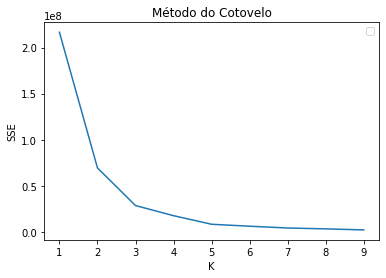

<ipython-input-63-7cac5e171799>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['DR'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['PRB'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['EB'][i+Us.index[0]]= 0
<ipython-input-63-7cac5e171799>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

fatiaVazaoAgregada [6016.502799225105]
antenasNecessariasParaSuprirUmMomento [{'id': 9.0, 'DrMean': 2052.05871856564}, {'id': 24.0, 'DrMean': 1075.305816804041}, {'id': 4.0, 'DrMean': 967.8942659453699}, {'id': 5.0, 'DrMean': 1212.2125831815783}, {'id': 10.0, 'DrMean': 4107.26217456049}]
Momento Atual -------------------------------------------------------------------------------------------------- 20


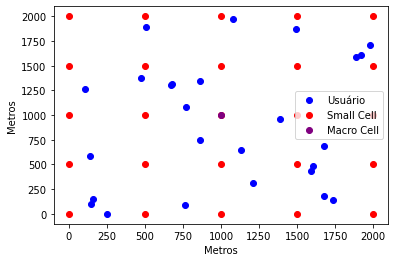

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
<ipython-input-70-a5e07d73fc62>:33: RuntimeWarning: invalid value encountered in double_scalars
  "DataRateMean": TotalDataRate/TotalUsers,


FatiasVazao [[4700.45061303039], [9400.90122606078], [14101.351839091169], [18801.80245212156], [23502.25306515195]]
vazaoAgregadaClusters [{'vazaoAgregada': 3499.729348971859, 'label': 5}, {'vazaoAgregada': 2832.3792061417766, 'label': 13}, {'vazaoAgregada': 2524.9061567060057, 'label': 1}, {'vazaoAgregada': 2283.861366960703, 'label': 14}, {'vazaoAgregada': 2058.1260253384153, 'label': 2}, {'vazaoAgregada': 1767.3486175104808, 'label': 8}, {'vazaoAgregada': 1676.8208937643626, 'label': 7}, {'vazaoAgregada': 1227.4505467650265, 'label': 11}, {'vazaoAgregada': 1089.1313632652411, 'label': 6}, {'vazaoAgregada': 1049.0267627901324, 'label': 12}, {'vazaoAgregada': 736.2496554367117, 'label': 3}, {'vazaoAgregada': 712.6777625754023, 'label': 4}, {'vazaoAgregada': 698.1406435561139, 'label': 9}, {'vazaoAgregada': 496.68067297778464, 'label': 15}, {'vazaoAgregada': 444.263126812015, 'label': 16}, {'vazaoAgregada': 405.46091557991497, 'label': 10}, {'vazaoAgregada': 0.0, 'label': 0}, {'vazaoA

sse [98573002.48488975, 29671727.28510138, 13841673.425521571, 7541519.29698766, 4900690.983626908, 3539276.121911701, 2271391.214849892, 1680187.0581777925, 1112427.7054601407]


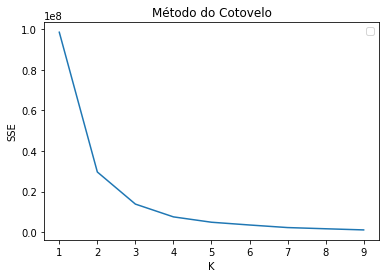

<ipython-input-63-7cac5e171799>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['DR'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['PRB'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['EB'][i+Us.index[0]]= 0
<ipython-input-63-7cac5e171799>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

fatiaVazaoAgregada [4700.45061303039]
antenasNecessariasParaSuprirUmMomento [{'id': 9.0, 'DrMean': 1089.1313632652411}, {'id': 12.0, 'DrMean': 736.2496554367117}, {'id': 17.0, 'DrMean': 2058.1260253384153}, {'id': 24.0, 'DrMean': 1767.3486175104808}]
Momento Atual -------------------------------------------------------------------------------------------------- 21


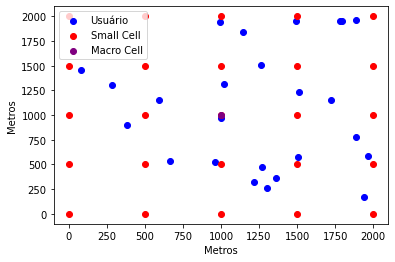

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


FatiasVazao [[6760.539239035269], [13521.078478070538], [20281.617717105804], [27042.156956141076], [33802.696195176344]]
vazaoAgregadaClusters [{'vazaoAgregada': 5886.893394151238, 'label': 6}, {'vazaoAgregada': 4665.790374394498, 'label': 3}, {'vazaoAgregada': 3317.7865771407487, 'label': 5}, {'vazaoAgregada': 3178.87534482632, 'label': 14}, {'vazaoAgregada': 2963.1113018415945, 'label': 12}, {'vazaoAgregada': 2798.158137578202, 'label': 1}, {'vazaoAgregada': 1804.6992216274248, 'label': 8}, {'vazaoAgregada': 1645.4700553648463, 'label': 4}, {'vazaoAgregada': 1444.1896868660879, 'label': 0}, {'vazaoAgregada': 1438.1528663112579, 'label': 17}, {'vazaoAgregada': 1367.8499908743763, 'label': 9}, {'vazaoAgregada': 1158.3330757003669, 'label': 11}, {'vazaoAgregada': 713.8840305132599, 'label': 13}, {'vazaoAgregada': 520.6006441478916, 'label': 15}, {'vazaoAgregada': 457.4839846612282, 'label': 7}, {'vazaoAgregada': 441.41750917699596, 'label': 10}, {'vazaoAgregada': 0.0, 'label': 2}, {'va

sse [179022018.0072953, 36725859.7680049, 23848234.59768502, 14893992.984962776, 8122354.106798306, 4759931.691687217, 3089018.2842847845, 1597896.6994257558, 745776.0747127472]


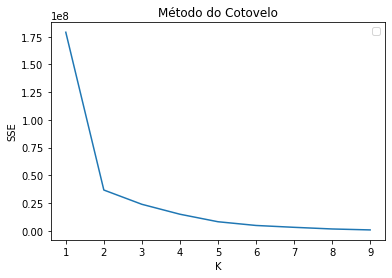

<ipython-input-63-7cac5e171799>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['DR'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['PRB'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['EB'][i+Us.index[0]]= 0
<ipython-input-63-7cac5e171799>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

fatiaVazaoAgregada [6760.539239035269]
antenasNecessariasParaSuprirUmMomento [{'id': 17.0, 'DrMean': 1804.6992216274248}, {'id': 25.0, 'DrMean': 1367.8499908743763}, {'id': 8.0, 'DrMean': 1645.4700553648463}, {'id': 12.0, 'DrMean': 2963.1113018415945}]
Momento Atual -------------------------------------------------------------------------------------------------- 22


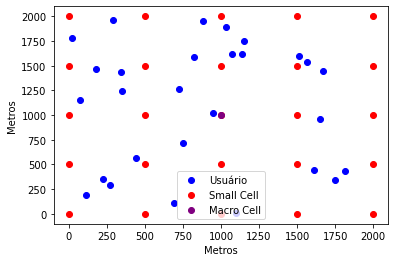

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


FatiasVazao [[5936.884621673895], [11873.76924334779], [17810.653865021683], [23747.53848669558], [29684.423108369472]]
vazaoAgregadaClusters [{'vazaoAgregada': 4326.000796629182, 'label': 6}, {'vazaoAgregada': 3274.7194322609976, 'label': 3}, {'vazaoAgregada': 3127.5189456908665, 'label': 13}, {'vazaoAgregada': 2679.10335689374, 'label': 4}, {'vazaoAgregada': 1858.1859332908807, 'label': 1}, {'vazaoAgregada': 1707.0625474528592, 'label': 10}, {'vazaoAgregada': 1700.6208100754911, 'label': 14}, {'vazaoAgregada': 1604.8373436764332, 'label': 2}, {'vazaoAgregada': 1551.8160979667389, 'label': 8}, {'vazaoAgregada': 1517.6455975795723, 'label': 16}, {'vazaoAgregada': 1500.1769789176099, 'label': 7}, {'vazaoAgregada': 1236.6821195882362, 'label': 12}, {'vazaoAgregada': 1044.6374261500353, 'label': 9}, {'vazaoAgregada': 805.8880984959536, 'label': 17}, {'vazaoAgregada': 694.8911852404195, 'label': 5}, {'vazaoAgregada': 590.8605637054754, 'label': 15}, {'vazaoAgregada': 463.7758747549785, 'la

sse [136709762.19313377, 38632005.150626525, 24304812.3173605, 14813257.906604107, 8370108.092279595, 4626792.649647845, 2831793.92557821, 1174240.2350972327, 704902.8551145236]


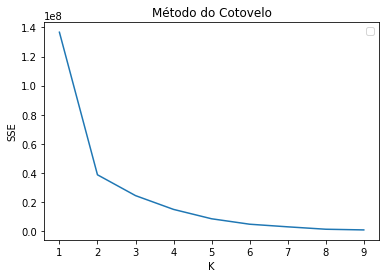

<ipython-input-63-7cac5e171799>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['DR'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['PRB'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['EB'][i+Us.index[0]]= 0
<ipython-input-63-7cac5e171799>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

fatiaVazaoAgregada [5936.884621673895]
antenasNecessariasParaSuprirUmMomento [{'id': 14.0, 'DrMean': 1551.8160979667389}, {'id': 15.0, 'DrMean': 1858.1859332908807}, {'id': 19.0, 'DrMean': 2679.10335689374}]
Momento Atual -------------------------------------------------------------------------------------------------- 23


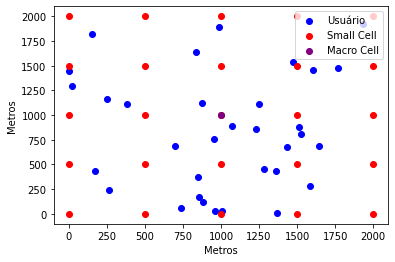

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


FatiasVazao [[5703.626278325488], [11407.252556650976], [17110.87883497646], [22814.50511330195], [28518.131391627438]]
vazaoAgregadaClusters [{'vazaoAgregada': 3789.499141866286, 'label': 4}, {'vazaoAgregada': 3437.623028456784, 'label': 2}, {'vazaoAgregada': 3096.468820160246, 'label': 11}, {'vazaoAgregada': 2719.3562221836078, 'label': 7}, {'vazaoAgregada': 2662.392778295988, 'label': 8}, {'vazaoAgregada': 2222.202477972852, 'label': 10}, {'vazaoAgregada': 1793.1445772347652, 'label': 5}, {'vazaoAgregada': 1256.003226886483, 'label': 12}, {'vazaoAgregada': 1128.1613460494025, 'label': 16}, {'vazaoAgregada': 1128.0520418024576, 'label': 3}, {'vazaoAgregada': 1042.679586096277, 'label': 14}, {'vazaoAgregada': 1004.9339778813656, 'label': 9}, {'vazaoAgregada': 989.8687578800684, 'label': 0}, {'vazaoAgregada': 787.132337494595, 'label': 13}, {'vazaoAgregada': 557.1661136681071, 'label': 1}, {'vazaoAgregada': 468.6076984182339, 'label': 17}, {'vazaoAgregada': 434.83925927991794, 'label':

sse [279086978.2552433, 106216990.10968223, 38548510.32027122, 19863677.45458054, 11772694.21702687, 6329043.05242819, 4482984.26537583, 3178486.2133264923, 1972546.8025954305]


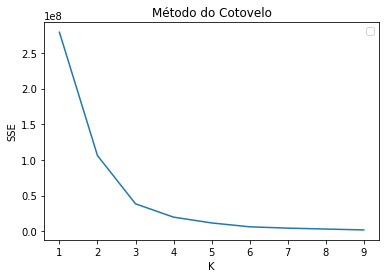

<ipython-input-63-7cac5e171799>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['DR'][i+Us.index[0]] =T*PR
<ipython-input-63-7cac5e171799>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['PRB'][i+Us.index[0]] =PR
<ipython-input-63-7cac5e171799>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['EB'][i+Us.index[0]]= IND + 1
<ipython-input-63-7cac5e171799>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of

fatiaVazaoAgregada [5703.626278325488]
antenasNecessariasParaSuprirUmMomento [{'id': 13.0, 'DrMean': 1042.679586096277}, {'id': 17.0, 'DrMean': 989.8687578800684}, {'id': 11.0, 'DrMean': 3437.623028456784}, {'id': 4.0, 'DrMean': 2662.392778295988}]
Momento Atual -------------------------------------------------------------------------------------------------- 24


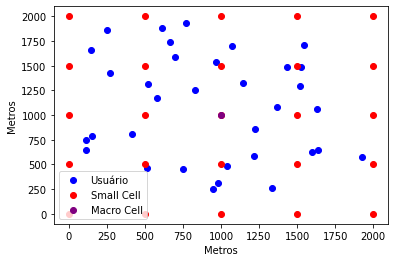

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


FatiasVazao [[4591.187424769036], [9182.374849538071], [13773.562274307107], [18364.749699076143], [22955.93712384518]]
vazaoAgregadaClusters [{'vazaoAgregada': 3141.61196276662, 'label': 9}, {'vazaoAgregada': 2915.8591994066073, 'label': 5}, {'vazaoAgregada': 2888.8395359496335, 'label': 3}, {'vazaoAgregada': 2093.12187016736, 'label': 0}, {'vazaoAgregada': 1914.3021220620462, 'label': 6}, {'vazaoAgregada': 1902.250321395127, 'label': 10}, {'vazaoAgregada': 1456.8644463165722, 'label': 11}, {'vazaoAgregada': 1178.7489343403897, 'label': 2}, {'vazaoAgregada': 1173.6327344617853, 'label': 14}, {'vazaoAgregada': 1051.035091355599, 'label': 4}, {'vazaoAgregada': 977.3238424811209, 'label': 13}, {'vazaoAgregada': 766.7867896098537, 'label': 12}, {'vazaoAgregada': 586.1429070593589, 'label': 8}, {'vazaoAgregada': 483.5909313971017, 'label': 1}, {'vazaoAgregada': 425.82643507599676, 'label': 15}, {'vazaoAgregada': 0.0, 'label': 7}, {'vazaoAgregada': 0.0, 'label': 16}, {'vazaoAgregada': 0.0, 

sse [239436049.25931254, 68223720.80444285, 30308771.065955102, 12725581.346589018, 7807267.663426459, 5576833.428248489, 3985203.147814976, 2590510.179284236, 1845986.5693173222]


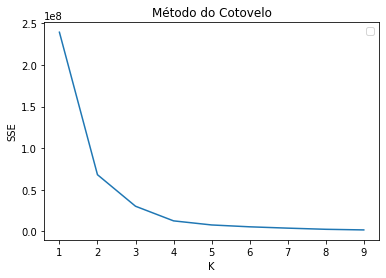

<ipython-input-63-7cac5e171799>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['DR'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['PRB'][i+Us.index[0]] =0
<ipython-input-63-7cac5e171799>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Us['EB'][i+Us.index[0]]= 0
<ipython-input-63-7cac5e171799>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

fatiaVazaoAgregada [4591.187424769036]
antenasNecessariasParaSuprirUmMomento [{'id': 9.0, 'DrMean': 766.7867896098537}, {'id': 12.0, 'DrMean': 1914.3021220620462}, {'id': 19.0, 'DrMean': 2888.8395359496335}]


<ipython-input-76-174873822d03>:154: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  MicroSortedByDR = FinalMicroSummary.groupby('MicroID')['DataRateMean','UsersConnected'].sum().sort_values(by='DataRateMean',ascending=False)
<ipython-input-76-174873822d03>:158: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  MicroSortedByUsersConnected = FinalMicroSummary.groupby('MicroID')['DataRateMean','UsersConnected'].sum().sort_values(by='UsersConnected',ascending=False)


In [ ]:
##iniciar o cenario
Us,Small,Macro,TU= StartScenario(50,5,1)
##Dividindo o dataframe de users por momento
momento = Us.groupby(Us.M)

# Listas para concatenar os frames de todos os momentos
#Primeira conexão
ListOfUserDataFrame =[]
ListOfSmallDataFrame =[]
ListOfMacroDataFrame = []
ListOfMicroSummary = []
ListOfMacroSummary = []
ListOfSaida=[]

#Conexão após ordenação por vazão média
ListOfUserDataFrameUserApproach =[]
ListOfSmallDataFrameUserApproach =[]
ListOfMacroDataFrameUserApproach = []
ListOfMicroSummaryUserApproach = []
ListOfMacroSummaryUserApproach = []
ListOfSaidaUserApproach=[]

#Conexão após clusterização pelo k-means
ListOfUserDataFrameKMeansApproach =[]
ListOfSmallDataFrameKMeansApproach =[]
ListOfMacroDataFrameKMeansApproach = []
ListOfMicroSummaryKMeansApproach = []
ListOfMacroSummaryKMeansApproach = []
ListOfSaidaKMeansApproach=[]


smallsNosMomentos = []

for moment in range(24):
 UserFrameInGivenMoment = momento.get_group(moment)
 print("Momento Atual --------------------------------------------------------------------------------------------------", moment+1)
 #Plotando o cenário
 plt.scatter(UserFrameInGivenMoment['X'], UserFrameInGivenMoment['Y'], marker='o', c = 'blue', label='Usuário')
 plt.scatter(Small['X'], Small['Y'], marker='o', c = 'red', label='Small Cell')
 plt.scatter(Macro['X'], Macro['Y'], marker='o', c = 'purple', label='Macro Cell')
 plt.xlabel("Metros")
 plt.ylabel("Metros")
 plt.legend()
 plt.show()

 #Calculando
 SaidaSelect, UsuarioSelect, SmallSelect, MacroSelect = selectAntenna(25,UserFrameInGivenMoment,Small,Macro)

 #Adicionando os dataframes de todos os momentos em arrays
 ListOfSmallDataFrame.append(SmallSelect)
 ListOfSaida.append(SaidaSelect)
 ListOfUserDataFrame.append(UsuarioSelect)
 ListOfMacroDataFrame.append(MacroSelect)

 #Calculando os summaries
 MicroSummary,MacroSummary = CalcSummary(UsuarioSelect,SmallSelect,MacroSelect, moment)

 #Adicionando os dataframes de todos os momentos em arrays
 ListOfMacroSummary.append(MacroSummary)
 ListOfMicroSummary.append(MicroSummary)


 #Fatiando a vazão agregada do momento
 fatiasVazao = CalcFatiasVazao(MicroSummary)

  #Fatiando em [0]: 20%, [1]: 40%, [2]: 60%,[3]: 80%,[4]: 100%
 fatiaAtual = fatiasVazao[0]

 #---------------------------------------------------KMEANS-------------------------------------------------------------------------------------------


 #Clusterização
 resultadoCluster = clusterizationAndExtraction(MicroSummary, fatiaAtual )


 #Desligar antenas que não são necessárias e reconectar
 SaidaKMeansApproachReconnect, UserKMeansApproachReconnect, SmallKMeansApproachReconnect, MacroKMeansApproachReconnect = turnOffAndReconnect(Small, resultadoCluster, UserFrameInGivenMoment, Macro)

 #Redistribuição de PRBS
 UsuarioRedis, SmallRedis = RedistribuiPRB(UserKMeansApproachReconnect,SmallKMeansApproachReconnect)

 #Calculando Summary Novamente
 MicroSummaryKMeansApproach,MacroSummaryKMeansApproach = CalcSummary(UserKMeansApproachReconnect,SmallKMeansApproachReconnect,MacroKMeansApproachReconnect, moment)
 #Adicionando os dataframes de todos os momentos em arrays APÓS RECONEXAO
 ListOfSaidaKMeansApproach.append(SaidaKMeansApproachReconnect)
 ListOfUserDataFrameKMeansApproach.append(UsuarioRedis)
 ListOfSmallDataFrameKMeansApproach.append(SmallRedis)
 ListOfMacroDataFrameKMeansApproach.append(MacroKMeansApproachReconnect)
 ListOfMacroSummaryKMeansApproach.append(MacroSummaryKMeansApproach)
 ListOfMicroSummaryKMeansApproach.append(MicroSummaryKMeansApproach)


 #-----------------------------------------------------------Ordenação por usuários ---------------------------------------------------------------------

 #Ordenando por DR
 moment0SmallsSortedByDr = SortByUsers(MicroSummary)

 #Calculando antenas necessarias
 result = CalcNecessaryAntennas(fatiaAtual, moment0SmallsSortedByDr )

 #Desligar antenas que não são necessárias e reconectar
 SaidaUserApproachReconnect, UserUserApproachReconnect, SmallUserApproachReconnect, MacroUserApproachReconnect = turnOffAndReconnect(Small, result, UserFrameInGivenMoment, Macro)

 #Redistribuição de PRBS
 UsuarioRedis, SmallRedis = RedistribuiPRB(UserUserApproachReconnect,SmallUserApproachReconnect)

 #Calculando Summary Novamente
 MicroSummaryUserApproach,MacroSummaryUserApproach = CalcSummary(UserUserApproachReconnect,SmallUserApproachReconnect,MacroUserApproachReconnect, moment)
 #Adicionando os dataframes de todos os momentos em arrays APÓS RECONEXAO
 ListOfSaidaUserApproach.append(SaidaUserApproachReconnect)
 ListOfUserDataFrameUserApproach.append(UsuarioRedis)
 ListOfSmallDataFrameUserApproach.append(SmallRedis)
 ListOfMacroDataFrameUserApproach.append(MacroUserApproachReconnect)
 ListOfMacroSummaryUserApproach.append(MacroSummaryUserApproach)
 ListOfMicroSummaryUserApproach.append(MicroSummaryUserApproach)

 #------------------------------------------------------------------------------------------------------------------------------------------------------------

 smallsNosMomentos.append(Small)

 #Zerando micros e macros para o próximo momento
 Small = []
 Macro = []
 Small = CriarSmall(5,2000,2000,StationBase)
 Macro = CriarMacros(1,StationMacro)
#end of for

#Concatenando o array de dataframe em um único
FinalSaidaDataFrame = pd.concat(ListOfSaida)
FinalUserDataFrame = pd.concat(ListOfUserDataFrame)
FinalSmallDataFrame = pd.concat(ListOfSmallDataFrame)
FinalMacroDataFrame = pd.concat(ListOfMacroDataFrame)
FinalMicroSummary = pd.concat(ListOfMicroSummary)
FinalMacroSummary = pd.concat(ListOfMacroSummary)

#Concatenando o array de dataframe APÓS RECONEXÃO baseada na VAZÃO MÉDIA em um único dataframe
FinalSaidaDataFrameUserApproach = pd.concat(ListOfSaidaUserApproach)
FinalUserDataFrameUserApproach = pd.concat(ListOfUserDataFrameUserApproach)
FinalSmallDataFrameUserApproach = pd.concat(ListOfSmallDataFrameUserApproach)
FinalMacroDataFrameUserApproach = pd.concat(ListOfMacroDataFrameUserApproach)
FinalMicroSummaryUserApproach = pd.concat(ListOfMicroSummaryUserApproach)
FinalMacroSummaryUserApproach = pd.concat(ListOfMacroSummaryUserApproach)

#Concatenando o array de dataframe APÓS RECONEXÃO baseada na CLUSTERIZAÇÃO pelo K-MEANS em um único dataframe
FinalSaidaDataFrameKMeansApproach = pd.concat(ListOfSaidaKMeansApproach)
FinalUserDataFrameKMeansApproach = pd.concat(ListOfUserDataFrameKMeansApproach)
FinalSmallDataFrameKMeansApproach = pd.concat(ListOfSmallDataFrameKMeansApproach)
FinalMacroDataFrameKMeansApproach = pd.concat(ListOfMacroDataFrameKMeansApproach)
FinalMicroSummaryKMeansApproach = pd.concat(ListOfMicroSummaryKMeansApproach)
FinalMacroSummaryKMeansApproach = pd.concat(ListOfMacroSummaryKMeansApproach)

#ORDENAÇÃO
#Ordenando Micros por média de DataRate
MicroSortedByDR = FinalMicroSummary.groupby('MicroID')['DataRateMean','UsersConnected'].sum().sort_values(by='DataRateMean',ascending=False)
atualizarColunaDataRate = MicroSortedByDR['DataRateMean']/24
MicroSortedByDR = MicroSortedByDR.replace (MicroSortedByDR['DataRateMean'].values, atualizarColunaDataRate)
#Ordenando Micros por quantidade de usuários conectados
MicroSortedByUsersConnected = FinalMicroSummary.groupby('MicroID')['DataRateMean','UsersConnected'].sum().sort_values(by='UsersConnected',ascending=False)
atualizarColunaDataRate = MicroSortedByUsersConnected['DataRateMean']/24
MicroSortedByUsersConnected = MicroSortedByUsersConnected.replace (MicroSortedByUsersConnected['DataRateMean'].values, atualizarColunaDataRate)


FinalSaidaDataFrame.to_excel("Saida-CalculoResults.xlsx")
FinalUserDataFrame.to_excel("User.xlsx")
FinalSmallDataFrame.to_excel("Small.xlsx")
FinalMacroDataFrame.to_excel("Macro.xlsx")
FinalMicroSummary.to_excel("MicroSummary.xlsx")
FinalMacroSummary.to_excel("MacroSummary.xlsx")

FinalSaidaDataFrameUserApproach.to_excel("Saida-CalculoResultsUserApproach.xlsx")
FinalUserDataFrameUserApproach.to_excel("UserUserApproach.xlsx")
FinalSmallDataFrameUserApproach.to_excel("SmallUserApproach.xlsx")
FinalMacroDataFrameUserApproach.to_excel("MacroUserApproach.xlsx")
FinalMicroSummaryUserApproach.to_excel("MicroSummaryUserApproach.xlsx")
FinalMacroSummaryUserApproach.to_excel("MacroSummaryUserApproach.xlsx")

FinalSaidaDataFrameKMeansApproach.to_excel("Saida-CalculoResultsKMeansApproach.xlsx")
FinalUserDataFrameKMeansApproach.to_excel("UserKMeansApproach.xlsx")
FinalSmallDataFrameKMeansApproach.to_excel("SmallKMeansApproach.xlsx")
FinalMacroDataFrameKMeansApproach.to_excel("MacroKMeansApproach.xlsx")
FinalMicroSummaryKMeansApproach.to_excel("MicroSummaryKMeansApproach.xlsx")
FinalMacroSummaryKMeansApproach.to_excel("MacroSummaryKMeansApproach.xlsx")

MicroSortedByDR.to_excel("MicroSortedByDR.xlsx")
MicroSortedByUsersConnected.to_excel("MicroSortedByUsersConnected.xlsx")


# New Section

# New Section